# Evaluation
Please note - do NOT click "Run all" - each segment should be self-explanatory as to which cells to run

# Imports

In [1]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3336, done.
remote: Counting objects: 100% (3336/3336), done.
remote: Compressing objects: 100% (2769/2769), done.
remote: Total 3336 (delta 880), reused 1433 (delta 517), pack-reused 0
Receiving objects: 100% (3336/3336), 34.33 MiB | 32.85 MiB/s, done.
Resolving deltas: 100% (880/880), done.


In [2]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1692480 sha256=a445f6c17ded587e66866d59ae1156d841d202ed700168995b101f341b0132fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-9ub0x6e5/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=b1e283947ccf1468020a241db89ce97794166fa7ed943aad8201f391358eecc7
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=8c9f9066ef9ed6e0cdbe30fb687dbe2347ea5cb698c908910ad1b5a7b2c38ad7
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for avro-python3: filename=avro_python3-1.10.2-py3-none-any.whl size=44010 sha256=797c6c499c0daf2ff555dba92fac467751d9adef2316107aac

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
!pip show opencv-python
!pip show opencv-python-headless
!pip uninstall --yes opencv-python-headless==4.5.5.64
!pip install opencv-python-headless==4.5.2.52

Name: opencv-python
Version: 4.1.2.30
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: None
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy
Required-by: lvis, imgaug, dopamine-rl, albumentations
Name: opencv-python-headless
Version: 4.5.5.64
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: None
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy
Required-by: tf-models-official
Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Successfully uninstalled opencv-python-headless-4.5.5.64
     |████████████████████████████████| 38.2 MB 66.5 MB/s 


In [4]:
%matplotlib inline

import numpy as np # linear algebra

# For drawing Bboxes to produce ground_truths
from object_detection.utils import colab_utils

# For showing images with Bboxes
import matplotlib
import matplotlib.pyplot as plt
from object_detection.utils import visualization_utils as viz_utils
from PIL import Image
from IPython.display import Image as IPyImage
from six import BytesIO

# File management
import os 
from os import path
import glob
from google.colab import files
import shutil

import cv2 # For video conversion to frames

# For producing dummy predictions
from random import gauss
from random import uniform

# For conversion of model output
import json

In [5]:
labels = ("yield_sign", "pedestrians_crossing_sign", "no_entry_sign", "chevron_left_sign", "chevron_right_sign", "parking_sign",
         "stop_sign", "60mph_sign", "30mph_sign", "one_way_sign",
         "speed_bump_sign", "no_left_turn_sign", "no_heavy_goods_vehicles_sign", "no_right_turn_sign", "children_sign")

# Select Video

In [ ]:
vidcap = cv2.VideoCapture('30MPH_Dusk_Short.mp4')
success,image = vidcap.read()
count = 0
fps = 30 # Input data is 30fps
# FPS should be set depending on the video used, to give about 60 frames:
#     -> NoEntryDaylight_Short.mp4 = 30 -> frameskipcount = 1
#     -> GiveWay_OneWay_Daylight_Short.mp4 = 15 -> frameskipcount = 2
#     -> GiveWay_NoRightTurn_NoWay_Dusk_Short.mp4 = 30 -> frameskipcount = 1
#     -> 30MPH_Dusk_Short.mp4 = 30 -> frameskipcount = 1
frameskipcount = 30/fps
print(frameskipcount)
countforskip = 0

if path.exists('frames') == False:
    os.mkdir('frames')
else:
    shutil.rmtree('frames')
    os.mkdir('frames')

while success:
    if path.exists("frames/frame%s.jpg" % str(count).zfill(4)) == False and countforskip == frameskipcount:
        cv2.imwrite("frames/frame%s.jpg" % str(count).zfill(4), image)     # save frame as JPEG file      
        success,image = vidcap.read()
        count += 1
        countforskip = 0
    else:
        success,image = vidcap.read()
        countforskip += 1

images = glob.glob(f"frames/*.jpg")
images.sort()
frames = [Image.open(image) for image in images]
frame_one = frames[0]
frame_one.save("gif_test.gif", format="GIF", append_images=frames,
                save_all=True, duration=50, loop=0)
display(IPyImage(open("gif_test.gif", 'rb').read()))

1.0


## Define image array and save frames

In [ ]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
test_image_dir = 'frames/'
test_images_np = []
for i in range(0, count-1):
    image_path = os.path.join(test_image_dir, 'frame' + str(i).zfill(4) + '.jpg')
    test_images_np.append(load_image_into_numpy_array(image_path))

In [ ]:
# Save the frames so they can be passed into the model
!zip -r frames.zip frames/

  adding: frames/ (stored 0%)
  adding: frames/frame0013.jpg (deflated 0%)
  adding: frames/frame0014.jpg (deflated 0%)
  adding: frames/frame0037.jpg (deflated 1%)
  adding: frames/frame0047.jpg (deflated 1%)
  adding: frames/frame0053.jpg (deflated 1%)
  adding: frames/frame0015.jpg (deflated 0%)
  adding: frames/frame0040.jpg (deflated 0%)
  adding: frames/frame0039.jpg (deflated 1%)
  adding: frames/frame0031.jpg (deflated 0%)
  adding: frames/frame0026.jpg (deflated 0%)
  adding: frames/frame0049.jpg (deflated 1%)
  adding: frames/frame0016.jpg (deflated 0%)
  adding: frames/frame0001.jpg (deflated 0%)
  adding: frames/frame0011.jpg (deflated 1%)
  adding: frames/frame0012.jpg (deflated 1%)
  adding: frames/frame0008.jpg (deflated 1%)
  adding: frames/frame0054.jpg (deflated 1%)
  adding: frames/frame0027.jpg (deflated 0%)
  adding: frames/frame0036.jpg (deflated 1%)
  adding: frames/frame0028.jpg (deflated 0%)
  adding: frames/frame0030.jpg (deflated 0%)
  adding: frames/frame000

In [ ]:
files.download("frames.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Previously Saved gt_boxes

### GT_BOXES for NoEntry_Daylight_Short

In [6]:
# OLD GT_BOXES FROM ABOVE FOR NOENTRYDAYLIGHTSHORT
gt_boxes_0 = [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None]
gt_boxes_1 = gt_boxes_0
gt_boxes_2 = [np.array([[0.43774305, 0.51510417, 0.47440972, 0.53072917]]),
  np.array([[0.43607639, 0.51302083, 0.47440972, 0.53125   ]]),
  np.array([[0.44107639, 0.48541667, 0.47940972, 0.50208333]]),
  np.array([[0.44107639, 0.46666667, 0.47607639, 0.48385417]]),
  np.array([[0.42940972, 0.45677083, 0.48274305, 0.47447917]]),
  np.array([[0.43440972, 0.47291667, 0.47940972, 0.49114583]]),
  np.array([[0.43940972, 0.50208333, 0.47607639, 0.5203125 ]]),
  np.array([[0.43607639, 0.52239583, 0.47607639, 0.54010417]]),
  np.array([[0.43607639, 0.5       , 0.47940972, 0.51927083]]),
  np.array([[0.43607639, 0.47552083, 0.48107639, 0.49322917]]),
  np.array([[0.43274305, 0.46302083, 0.47940972, 0.48072917]]),
  np.array([[0.43940972, 0.4640625 , 0.48107639, 0.4828125 ]]),
  np.array([[0.43440972, 0.45572917, 0.48274305, 0.475     ]]),
  np.array([[0.42774305, 0.4546875 , 0.47940972, 0.475     ]]),
  np.array([[0.42607639, 0.44635417, 0.48274305, 0.46822917]]),
  np.array([[0.41940972, 0.4515625 , 0.46940972, 0.47291667]]),
  np.array([[0.41274305, 0.45208333, 0.46774305, 0.47708333]]),
  np.array([[0.40107639, 0.4640625 , 0.46274305, 0.4859375 ]]),
  np.array([[0.40774305, 0.45885417, 0.45940972, 0.48125   ]]),
  np.array([[0.41440972, 0.44635417, 0.46774305, 0.4703125 ]]),
  np.array([[0.40940972, 0.43072917, 0.46774305, 0.45572917]]),
  np.array([[0.41440972, 0.43072917, 0.46940972, 0.45208333]]),
  np.array([[0.41440972, 0.4203125 , 0.47440972, 0.44427083]]),
  np.array([[0.41274305, 0.41510417, 0.47607639, 0.4390625 ]]),
  np.array([[0.40774305, 0.41875   , 0.47440972, 0.4453125 ]]),
  np.array([[0.39940972, 0.43333333, 0.45940972, 0.45625   ]]),
  np.array([[0.39440972, 0.46458333, 0.45940972, 0.49114583]]),
  np.array([[0.40607639, 0.5109375 , 0.46274305, 0.53541667]]),
  np.array([[0.41440972, 0.53958333, 0.47440972, 0.56614583]]),
  np.array([[0.41440972, 0.55416667, 0.48607639, 0.58125   ]]),
  np.array([[0.41607639, 0.5671875 , 0.47607639, 0.5953125 ]]),
  np.array([[0.41607639, 0.57083333, 0.48274305, 0.6       ]]),
  np.array([[0.42607639, 0.5828125 , 0.49274305, 0.61458333]]),
  np.array([[0.42107639, 0.58958333, 0.49274305, 0.6171875 ]]),
  np.array([[0.44607639, 0.59166667, 0.51440972, 0.62291667]]),
  np.array([[0.44940972, 0.60364583, 0.51607639, 0.6359375 ]]),
  np.array([[0.42940972, 0.61302083, 0.50774305, 0.6453125 ]]),
  np.array([[0.41274305, 0.61927083, 0.48274305, 0.6515625 ]]),
  np.array([[0.41274305, 0.63958333, 0.48940972, 0.66927083]]),
  np.array([[0.40274305, 0.65364583, 0.47440972, 0.68802083]]),
  np.array([[0.36940972, 0.6671875 , 0.44940972, 0.7       ]]),
  np.array([[0.37274305, 0.6765625 , 0.44607639, 0.71041667]]),
  np.array([[0.36774305, 0.69114583, 0.44274305, 0.72552083]]),
  np.array([[0.36107639, 0.70989583, 0.44274305, 0.74322917]]),
  np.array([[0.36107639, 0.72291667, 0.44774305, 0.75625   ]]),
  np.array([[0.36607639, 0.74114583, 0.45940972, 0.7765625 ]]),
  np.array([[0.37940972, 0.76041667, 0.47274305, 0.79739583]]),
  np.array([[0.39607639, 0.78177083, 0.47440972, 0.8203125 ]]),
  np.array([[0.38274305, 0.8046875 , 0.46774305, 0.8453125 ]]),
  np.array([[0.39274305, 0.83958333, 0.48274305, 0.87864583]]),
  np.array([[0.38274305, 0.87447917, 0.47440972, 0.9140625 ]]),
  np.array([[0.38107639, 0.9046875 , 0.47440972, 0.94010417]]),
  np.array([[0.36607639, 0.9234375 , 0.47440972, 0.96041667]]),
  np.array([[0.35607639, 0.9328125 , 0.46940972, 0.97135417]]),
  np.array([[0.34774305, 0.94322917, 0.44607639, 0.97916667]]),
  np.array([[0.33607639, 0.9484375 , 0.44274305, 0.9859375 ]]),
  np.array([[0.32940972, 0.95885417, 0.43274305, 0.99427083]]),
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None]
gt_boxes_3 = gt_boxes_0
gt_boxes_4 = gt_boxes_0
gt_boxes_5 = gt_boxes_0
gt_boxes_6 = gt_boxes_0
gt_boxes_7 = gt_boxes_0
gt_boxes_8 = gt_boxes_0
gt_boxes_9 = gt_boxes_0
gt_boxes_10 = gt_boxes_0
gt_boxes_11 = gt_boxes_0
gt_boxes_12 = gt_boxes_0
gt_boxes_13 = gt_boxes_0
gt_boxes_14 = gt_boxes_0

### GT_BOXES for GiveWay_OneWay_Daylight_Short

In [52]:
# OLD GT_BOXES FROM ABOVE FOR NOENTRYDAYLIGHTSHORT
gt_boxes_0 = [np.array([[0.39274089, 0.5609375 , 0.43607422, 0.58333333]]),
 np.array([[0.38607422, 0.565625  , 0.43607422, 0.5875    ]]),
 np.array([[0.38774089, 0.56875   , 0.43107422, 0.59375   ]]),
 np.array([[0.37774089, 0.57291667, 0.42940755, 0.59895833]]),
 np.array([[0.37107422, 0.571875  , 0.41774089, 0.59479167]]),
 np.array([[0.36940755, 0.5734375 , 0.41940755, 0.60052083]]),
 np.array([[0.35940755, 0.57864583, 0.41774089, 0.60677083]]),
 np.array([[0.35107422, 0.58854167, 0.41440755, 0.6171875 ]]),
 np.array([[0.33940755, 0.59479167, 0.40274089, 0.6234375 ]]),
 np.array([[0.33607422, 0.60572917, 0.39607422, 0.63541667],
        [0.32774089, 0.165625  , 0.41107422, 0.20364583]]),
 np.array([[0.32107422, 0.615625  , 0.38440755, 0.64947917],
        [0.31774089, 0.14947917, 0.40940755, 0.19114583]]),
 np.array([[0.31274089, 0.62760417, 0.37774089, 0.66145833],
        [0.30607422, 0.13177083, 0.40107422, 0.17864583]]),
 np.array([[0.29774089, 0.63385417, 0.36440755, 0.66979167],
        [0.28940755, 0.1078125 , 0.38440755, 0.15729167]]),
 np.array([[0.27940755, 0.07395833, 0.38940755, 0.12239583],
        [0.28607422, 0.63177083, 0.35440755, 0.6671875 ]]),
 np.array([[0.26774089, 0.04270833, 0.37774089, 0.0953125 ],
        [0.26440755, 0.63125   , 0.33940755, 0.66822917]]),
 np.array([[0.24607422, 0.01458333, 0.36440755, 0.07135417],
        [0.24440755, 0.63802083, 0.32107422, 0.67864583]]),
 np.array([[0.22940755, 0.64114583, 0.31440755, 0.68489583],
        [0.23107422, 0.        , 0.36107422, 0.03697917]]),
 np.array([[0.22107422, 0.65989583, 0.29774089, 0.70104167]]),
 np.array([[0.20107422, 0.67708333, 0.28774089, 0.7203125 ]]),
 np.array([[0.18107422, 0.68385417, 0.26940755, 0.72916667]]),
 np.array([[0.15440755, 0.6703125 , 0.25440755, 0.71875   ]]),
 np.array([[0.13107422, 0.67864583, 0.22774089, 0.73020833]]),
 np.array([[0.10607422, 0.67239583, 0.21274089, 0.7265625 ]]),
 np.array([[0.07274089, 0.66197917, 0.18607422, 0.72239583]]),
 np.array([[0.04607422, 0.68645833, 0.15940755, 0.7421875 ]]),
 np.array([[0.01774089, 0.71197917, 0.13774089, 0.771875  ]]),
 np.array([[0.        , 0.73333333, 0.10440755, 0.7890625 ]]),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]
gt_boxes_1 = [None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]
gt_boxes_2 = gt_boxes_1
gt_boxes_3 = gt_boxes_1
gt_boxes_4 = gt_boxes_1
gt_boxes_5 = gt_boxes_1
gt_boxes_6 = gt_boxes_1
gt_boxes_7 = gt_boxes_1
gt_boxes_8 = gt_boxes_1
gt_boxes_9 = [None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 np.array([[0.43607422, 0.2171875 , 0.46107422, 0.22552083],
        [0.45107422, 0.23020833, 0.47607422, 0.23958333],
        [0.46274089, 0.40260417, 0.48607422, 0.41145833],
        [0.44774089, 0.415625  , 0.47274089, 0.42552083]]),
 np.array([[0.43107422, 0.23072917, 0.45274089, 0.23958333],
        [0.44440755, 0.2453125 , 0.46274089, 0.253125  ],
        [0.44774089, 0.4359375 , 0.46940755, 0.44583333],
        [0.45940755, 0.42291667, 0.48607422, 0.43072917]]),
 np.array([[0.42940755, 0.23333333, 0.46107422, 0.2421875 ],
        [0.44440755, 0.25      , 0.46440755, 0.25833333],
        [0.46274089, 0.43229167, 0.48607422, 0.44166667],
        [0.44774089, 0.44583333, 0.47274089, 0.45625   ]]),
 np.array([[0.43107422, 0.225     , 0.46107422, 0.2359375 ],
        [0.44274089, 0.24322917, 0.46774089, 0.25416667],
        [0.46107422, 0.43020833, 0.48440755, 0.44114583],
        [0.44274089, 0.4453125 , 0.46940755, 0.45572917]]),
 np.array([[0.42274089, 0.2296875 , 0.45274089, 0.24114583],
        [0.43607422, 0.25052083, 0.45940755, 0.259375  ],
        [0.45107422, 0.44166667, 0.48107422, 0.45052083],
        [0.43440755, 0.45572917, 0.46440755, 0.4671875 ]]),
 np.array([[0.41940755, 0.23854167, 0.45107422, 0.24791667],
        [0.43774089, 0.259375  , 0.46774089, 0.26979167],
        [0.45274089, 0.45625   , 0.48107422, 0.46614583],
        [0.43774089, 0.47239583, 0.46274089, 0.48333333]]),
 np.array([[0.42107422, 0.2375    , 0.45274089, 0.24895833],
        [0.43940755, 0.26197917, 0.46940755, 0.271875  ],
        [0.45274089, 0.46354167, 0.48107422, 0.4765625 ],
        [0.43440755, 0.48020833, 0.46440755, 0.49114583]]),
 np.array([[0.42774089, 0.2328125 , 0.46107422, 0.24375   ],
        [0.44774089, 0.2609375 , 0.47607422, 0.26979167],
        [0.45607422, 0.46979167, 0.48774089, 0.47916667],
        [0.43774089, 0.48333333, 0.46440755, 0.49479167]]),
 np.array([[0.41940755, 0.2265625 , 0.45440755, 0.23854167],
        [0.43940755, 0.25677083, 0.46440755, 0.265625  ],
        [0.45107422, 0.46979167, 0.47607422, 0.48072917],
        [0.42107422, 0.48541667, 0.45607422, 0.49635417]]),
 np.array([[0.42607422, 0.22135417, 0.45274089, 0.234375  ],
        [0.44440755, 0.25416667, 0.46940755, 0.26354167],
        [0.44440755, 0.47447917, 0.47607422, 0.4828125 ],
        [0.41774089, 0.48854167, 0.45607422, 0.5       ]]),
 np.array([[0.41274089, 0.22395833, 0.44274089, 0.23333333],
        [0.42940755, 0.25625   , 0.45607422, 0.26822917],
        [0.43107422, 0.484375  , 0.46274089, 0.49583333],
        [0.40440755, 0.50052083, 0.43774089, 0.51197917]]),
 np.array([[0.40940755, 0.21927083, 0.43940755, 0.2328125 ],
        [0.42774089, 0.2578125 , 0.45940755, 0.2671875 ],
        [0.43107422, 0.490625  , 0.45607422, 0.5015625 ],
        [0.39774089, 0.50416667, 0.43607422, 0.51979167]]),
 np.array([[0.41940755, 0.21145833, 0.45940755, 0.221875  ],
        [0.44607422, 0.25052083, 0.47607422, 0.26197917],
        [0.43774089, 0.48958333, 0.46940755, 0.5       ],
        [0.41107422, 0.5078125 , 0.43940755, 0.52083333]]),
 np.array([[0.42274089, 0.203125  , 0.45440755, 0.21614583],
        [0.44607422, 0.24583333, 0.47607422, 0.25677083],
        [0.43774089, 0.49270833, 0.47107422, 0.503125  ],
        [0.40107422, 0.50833333, 0.43940755, 0.521875  ]]),
 np.array([[0.42607422, 0.2015625 , 0.45940755, 0.21666667],
        [0.44440755, 0.24635417, 0.47774089, 0.26041667],
        [0.43940755, 0.50052083, 0.46940755, 0.51145833],
        [0.40274089, 0.51875   , 0.43607422, 0.53177083]]),
 np.array([[0.42107422, 0.18854167, 0.46107422, 0.20625   ],
        [0.44774089, 0.23854167, 0.47940755, 0.2515625 ],
        [0.43107422, 0.49791667, 0.46774089, 0.5109375 ],
        [0.39440755, 0.515625  , 0.43440755, 0.53229167]]),
 np.array([[0.41940755, 0.175     , 0.45940755, 0.190625  ],
        [0.44774089, 0.22916667, 0.48440755, 0.24010417],
        [0.42607422, 0.49322917, 0.46107422, 0.50625   ],
        [0.38107422, 0.51041667, 0.42607422, 0.52916667]]),
 np.array([[0.41107422, 0.15677083, 0.46107422, 0.17447917],
        [0.43774089, 0.21354167, 0.47940755, 0.22916667],
        [0.41274089, 0.48489583, 0.45607422, 0.5       ],
        [0.37107422, 0.50625   , 0.41440755, 0.521875  ]]),
 np.array([[0.40440755, 0.1578125 , 0.45440755, 0.17291667],
        [0.43107422, 0.21510417, 0.46940755, 0.23072917],
        [0.41274089, 0.49635417, 0.45107422, 0.509375  ],
        [0.36940755, 0.5140625 , 0.41107422, 0.534375  ]]),
 np.array([[0.40274089, 0.15520833, 0.44607422, 0.17083333],
        [0.43607422, 0.2203125 , 0.46774089, 0.23229167],
        [0.41774089, 0.50520833, 0.45274089, 0.52239583],
        [0.36774089, 0.52604167, 0.41107422, 0.54583333]]),
 np.array([[0.40940755, 0.14635417, 0.45440755, 0.1640625 ],
        [0.44274089, 0.21666667, 0.47774089, 0.2296875 ],
        [0.42274089, 0.51041667, 0.45940755, 0.52395833],
        [0.37107422, 0.53177083, 0.41774089, 0.55104167]]),
 np.array([[0.40940755, 0.13958333, 0.45440755, 0.15729167],
        [0.44607422, 0.2125    , 0.48107422, 0.22708333],
        [0.42107422, 0.515625  , 0.45940755, 0.52864583],
        [0.36940755, 0.53802083, 0.40607422, 0.55625   ]]),
 np.array([[0.40440755, 0.13125   , 0.45107422, 0.14895833],
        [0.43774089, 0.20677083, 0.48107422, 0.22239583],
        [0.42107422, 0.51822917, 0.45607422, 0.5328125 ],
        [0.36107422, 0.54166667, 0.40607422, 0.56510417]]),
 np.array([[0.40607422, 0.12239583, 0.45274089, 0.14114583],
        [0.44440755, 0.2046875 , 0.47774089, 0.21927083],
        [0.35607422, 0.5453125 , 0.40940755, 0.56822917],
        [0.42107422, 0.521875  , 0.45940755, 0.5375    ]]),
 np.array([[0.34607422, 0.55052083, 0.39440755, 0.56927083],
        [0.41440755, 0.52135417, 0.44774089, 0.53541667],
        [0.44274089, 0.196875  , 0.47774089, 0.2125    ],
        [0.40607422, 0.11302083, 0.45107422, 0.128125  ]]),
 np.array([[0.39774089, 0.10052083, 0.43440755, 0.11614583],
        [0.43107422, 0.190625  , 0.46440755, 0.203125  ],
        [0.32940755, 0.5484375 , 0.37607422, 0.57552083],
        [0.39607422, 0.52083333, 0.43774089, 0.53697917]]),
 np.array([[0.38440755, 0.08645833, 0.42940755, 0.10208333],
        [0.41940755, 0.18072917, 0.45940755, 0.1953125 ],
        [0.38774089, 0.51927083, 0.43107422, 0.53697917],
        [0.31440755, 0.5484375 , 0.36440755, 0.57395833]]),
 np.array([[0.37774089, 0.07395833, 0.42107422, 0.09166667],
        [0.41274089, 0.17291667, 0.45607422, 0.18802083],
        [0.38440755, 0.521875  , 0.42107422, 0.53697917],
        [0.30440755, 0.55364583, 0.35107422, 0.5796875 ]]),
 np.array([[0.37274089, 0.06822917, 0.41940755, 0.08489583],
        [0.41274089, 0.1734375 , 0.44774089, 0.18645833],
        [0.37940755, 0.53125   , 0.41774089, 0.546875  ],
        [0.29274089, 0.5640625 , 0.34774089, 0.58958333]]),
 np.array([[0.37274089, 0.0578125 , 0.41440755, 0.0765625 ],
        [0.41440755, 0.16822917, 0.45440755, 0.18385417],
        [0.38440755, 0.534375  , 0.42274089, 0.55260417],
        [0.28940755, 0.5703125 , 0.34607422, 0.59895833]]),
 np.array([[0.36774089, 0.0546875 , 0.41774089, 0.07604167],
        [0.41274089, 0.16927083, 0.45440755, 0.1859375 ],
        [0.38440755, 0.546875  , 0.42107422, 0.56354167],
        [0.27940755, 0.58385417, 0.33607422, 0.61197917]]),
 np.array([[0.35274089, 0.0546875 , 0.40607422, 0.07135417],
        [0.40440755, 0.17552083, 0.44774089, 0.19010417],
        [0.37940755, 0.5609375 , 0.42107422, 0.57864583],
        [0.26940755, 0.60208333, 0.33107422, 0.63125   ]]),
 np.array([[0.34774089, 0.05520833, 0.40440755, 0.07552083],
        [0.40107422, 0.1828125 , 0.43440755, 0.19947917],
        [0.37107422, 0.5796875 , 0.41274089, 0.596875  ],
        [0.25440755, 0.6234375 , 0.31774089, 0.6515625 ]]),
 np.array([[0.34440755, 0.0546875 , 0.39440755, 0.071875  ],
        [0.39774089, 0.18541667, 0.43940755, 0.2015625 ],
        [0.36774089, 0.59114583, 0.41274089, 0.6125    ],
        [0.24440755, 0.640625  , 0.31107422, 0.67239583]]),
 np.array([[0.35107422, 0.0390625 , 0.39774089, 0.0578125 ],
        [0.40440755, 0.178125  , 0.43940755, 0.19375   ],
        [0.36274089, 0.59270833, 0.40274089, 0.6109375 ],
        [0.23107422, 0.64375   , 0.29440755, 0.678125  ]]),
 np.array([[0.35940755, 0.01875   , 0.40940755, 0.03541667],
        [0.40940755, 0.15885417, 0.44774089, 0.175     ],
        [0.35440755, 0.58333333, 0.39774089, 0.60520833],
        [0.21274089, 0.640625  , 0.28107422, 0.67291667]]),
 np.array([[0.36774089, 0.        , 0.42107422, 0.009375  ],
        [0.41440755, 0.13854167, 0.45607422, 0.1546875 ],
        [0.34774089, 0.5703125 , 0.39607422, 0.58854167],
        [0.19440755, 0.63125   , 0.26107422, 0.66458333]]),
 np.array([[0.41440755, 0.12135417, 0.45274089, 0.13645833],
        [0.34440755, 0.56302083, 0.38440755, 0.58229167],
        [0.18107422, 0.62760417, 0.23940755, 0.66302083]]),
 np.array([[0.41440755, 0.10572917, 0.45940755, 0.12239583],
        [0.33940755, 0.55625   , 0.37940755, 0.58072917],
        [0.15607422, 0.62760417, 0.22940755, 0.66302083]]),
 np.array([[0.41440755, 0.08958333, 0.45607422, 0.10729167],
        [0.32940755, 0.55      , 0.37774089, 0.5703125 ],
        [0.12940755, 0.62291667, 0.20940755, 0.66458333]]),
 np.array([[0.40274089, 0.0765625 , 0.44607422, 0.09375   ],
        [0.31774089, 0.54322917, 0.36440755, 0.56770833],
        [0.10940755, 0.62604167, 0.18107422, 0.66458333]]),
 np.array([[0.39774089, 0.06822917, 0.43940755, 0.08697917],
        [0.30940755, 0.54479167, 0.35607422, 0.56614583],
        [0.08440755, 0.63177083, 0.16274089, 0.67291667]]),
 np.array([[0.38607422, 0.0703125 , 0.42774089, 0.0875    ],
        [0.29774089, 0.55885417, 0.35107422, 0.58072917],
        [0.06274089, 0.64739583, 0.14440755, 0.69322917]]),
 np.array([[0.05274089, 0.6859375 , 0.12774089, 0.73072917],
        [0.29774089, 0.58854167, 0.34774089, 0.61302083],
        [0.37607422, 0.08854167, 0.41440755, 0.10677083]]),
 np.array([[0.36274089, 0.103125  , 0.40607422, 0.12395833],
        [0.28940755, 0.615625  , 0.34274089, 0.640625  ],
        [0.03440755, 0.71770833, 0.11440755, 0.76458333]]),
 np.array([[0.36274089, 0.103125  , 0.41274089, 0.1234375 ],
        [0.28940755, 0.62395833, 0.34274089, 0.6484375 ],
        [0.01774089, 0.734375  , 0.10107422, 0.78177083]]),
 np.array([[0.37774089, 0.08854167, 0.42107422, 0.10677083],
        [0.28607422, 0.61458333, 0.34274089, 0.63958333],
        [0.00274089, 0.73177083, 0.08107422, 0.77916667]]),
 np.array([[0.38607422, 0.06614583, 0.42274089, 0.084375  ],
        [0.27774089, 0.59375   , 0.32774089, 0.62135417],
        [0.27774089, 0.59375   , 0.32774089, 0.62135417],
        [0.        , 0.71510417, 0.06274089, 0.7640625 ]]),
 np.array([[0.39440755, 0.053125  , 0.42940755, 0.071875  ],
        [0.27607422, 0.58229167, 0.32607422, 0.60833333]]),
 np.array([[0.27274089, 0.584375  , 0.32940755, 0.609375  ],
        [0.39274089, 0.0484375 , 0.43774089, 0.06875   ]]),
 np.array([[0.27274089, 0.578125  , 0.32274089, 0.603125  ],
        [0.40107422, 0.04166667, 0.44607422, 0.05885417]]),
 np.array([[0.40940755, 0.03177083, 0.45274089, 0.053125  ],
        [0.26440755, 0.5703125 , 0.31940755, 0.59635417]]),
 np.array([[0.41107422, 0.0296875 , 0.46274089, 0.04947917],
        [0.26274089, 0.56927083, 0.31274089, 0.5953125 ]])]
gt_boxes_10 = gt_boxes_1
gt_boxes_11 = gt_boxes_1
gt_boxes_12 = gt_boxes_1
gt_boxes_13 = gt_boxes_1
gt_boxes_14 = gt_boxes_1

### GT_BOXES for GiveWay_NoRightTurn_NoWay_Dusk_Short

In [94]:
gt_boxes_0 = [np.array([[0.41774089, 0.23177083, 0.48107422, 0.265625  ]]),
 np.array([[0.41940755, 0.22135417, 0.48440755, 0.2578125 ]]),
 np.array([[0.40940755, 0.21197917, 0.47274089, 0.24791667]]),
 np.array([[0.39607422, 0.20416667, 0.46440755, 0.2421875 ]]),
 np.array([[0.37607422, 0.19375   , 0.44607422, 0.23229167]]),
 np.array([[0.37274089, 0.1796875 , 0.44274089, 0.21927083]]),
 np.array([[0.35940755, 0.16822917, 0.44607422, 0.2109375 ]]),
 np.array([[0.34607422, 0.15625   , 0.43440755, 0.19895833]]),
 np.array([[0.35107422, 0.13958333, 0.43107422, 0.18541667]]),
 np.array([[0.33774089, 0.12604167, 0.42607422, 0.171875  ]]),
 np.array([[0.32940755, 0.11041667, 0.42607422, 0.15625   ]]),
 np.array([[0.31940755, 0.09635417, 0.41774089, 0.14114583]]),
 np.array([[0.30607422, 0.07916667, 0.40940755, 0.12864583]]),
 np.array([[0.28607422, 0.0625    , 0.39440755, 0.1125    ]]),
 np.array([[0.27274089, 0.040625  , 0.38607422, 0.09114583]]),
 np.array([[0.27107422, 0.02135417, 0.39274089, 0.06875   ]]),
 np.array([[0.25107422, 0.0015625 , 0.37940755, 0.0484375 ]]),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]
gt_boxes_1 = [None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]
gt_boxes_2 = [np.array([[0.48440755, 0.62916667, 0.51274089, 0.64114583]]),
 np.array([[0.48940755, 0.63072917, 0.51774089, 0.64322917]]),
 np.array([[0.48107422, 0.63385417, 0.51274089, 0.64635417]]),
 np.array([[0.47107422, 0.63854167, 0.50607422, 0.6515625 ]]),
 np.array([[0.45440755, 0.640625  , 0.48940755, 0.65364583]]),
 np.array([[0.45940755, 0.6421875 , 0.49274089, 0.65625   ]]),
 np.array([[0.45940755, 0.64635417, 0.48940755, 0.65885417]]),
 np.array([[0.45107422, 0.6484375 , 0.48607422, 0.6625    ]]),
 np.array([[0.45607422, 0.6515625 , 0.48940755, 0.6625    ]]),
 np.array([[0.45440755, 0.65364583, 0.48774089, 0.66510417]]),
 np.array([[0.45440755, 0.65625   , 0.49440755, 0.66927083]]),
 np.array([[0.45607422, 0.659375  , 0.48774089, 0.6703125 ]]),
 np.array([[0.45107422, 0.66458333, 0.48440755, 0.678125  ]]),
 np.array([[0.44274089, 0.6671875 , 0.48107422, 0.68020833]]),
 np.array([[0.44440755, 0.66510417, 0.48107422, 0.6796875 ]]),
 np.array([[0.44274089, 0.66510417, 0.47274089, 0.67760417]]),
 np.array([[0.43940755, 0.66510417, 0.47940755, 0.67864583]]),
 np.array([[0.43607422, 0.665625  , 0.47607422, 0.678125  ]]),
 np.array([[0.43940755, 0.66458333, 0.48107422, 0.67864583]]),
 np.array([[0.43607422, 0.66666667, 0.48107422, 0.68229167]]),
 np.array([[0.43774089, 0.66822917, 0.47774089, 0.68125   ]]),
 np.array([[0.44274089, 0.671875  , 0.47607422, 0.68541667]]),
 np.array([[0.43440755, 0.675     , 0.47274089, 0.68854167]]),
 np.array([[0.43607422, 0.68020833, 0.47607422, 0.69583333]]),
 np.array([[0.43440755, 0.6890625 , 0.47607422, 0.7046875 ]]),
 np.array([[0.43440755, 0.70052083, 0.47274089, 0.71354167]]),
 np.array([[0.43940755, 0.709375  , 0.47274089, 0.72447917]]),
 np.array([[0.43440755, 0.7203125 , 0.47274089, 0.7359375 ]]),
 np.array([[0.43607422, 0.7328125 , 0.47274089, 0.74895833]]),
 np.array([[0.42940755, 0.74635417, 0.46940755, 0.76145833]]),
 np.array([[0.42774089, 0.75677083, 0.46940755, 0.77239583]]),
 np.array([[0.42607422, 0.76614583, 0.47107422, 0.7828125 ]]),
 np.array([[0.42774089, 0.7734375 , 0.46940755, 0.78958333]]),
 np.array([[0.42107422, 0.77864583, 0.46774089, 0.79479167]]),
 np.array([[0.42107422, 0.78802083, 0.46440755, 0.803125  ]]),
 np.array([[0.42107422, 0.80104167, 0.46774089, 0.815625  ]]),
 np.array([[0.42107422, 0.81614583, 0.46440755, 0.83125   ]]),
 np.array([[0.42107422, 0.834375  , 0.46940755, 0.84895833]]),
 np.array([[0.41274089, 0.84791667, 0.46107422, 0.86354167]]),
 np.array([[0.41107422, 0.85572917, 0.45940755, 0.87395833]]),
 np.array([[0.40274089, 0.86302083, 0.44774089, 0.88125   ]]),
 np.array([[0.38940755, 0.86979167, 0.44274089, 0.88697917]]),
 np.array([[0.38440755, 0.87552083, 0.42940755, 0.89166667]]),
 np.array([[0.37274089, 0.87916667, 0.42107422, 0.89635417]]),
 np.array([[0.36274089, 0.8828125 , 0.41274089, 0.89895833]]),
 np.array([[0.36107422, 0.8828125 , 0.40940755, 0.90364583]]),
 np.array([[0.35440755, 0.8859375 , 0.40940755, 0.90364583]]),
 np.array([[0.35274089, 0.88541667, 0.40440755, 0.90677083]]),
 np.array([[0.34774089, 0.88697917, 0.40440755, 0.90677083]]),
 np.array([[0.34774089, 0.890625  , 0.39607422, 0.90989583]]),
 np.array([[0.34274089, 0.89479167, 0.40107422, 0.9140625 ]]),
 np.array([[0.34607422, 0.90208333, 0.39774089, 0.9203125 ]]),
 np.array([[0.34607422, 0.91041667, 0.39774089, 0.92708333]]),
 np.array([[0.35107422, 0.91822917, 0.40440755, 0.93854167]]),
 np.array([[0.35940755, 0.9328125 , 0.41274089, 0.95052083]]),
 np.array([[0.36774089, 0.94375   , 0.42774089, 0.96354167]]),
 np.array([[0.37607422, 0.95572917, 0.43107422, 0.971875  ]]),
 np.array([[0.38107422, 0.96458333, 0.43940755, 0.98489583]]),
 np.array([[0.38774089, 0.97760417, 0.44774089, 0.99583333]])]
gt_boxes_3 = gt_boxes_1
gt_boxes_4 = gt_boxes_1
gt_boxes_5 = gt_boxes_1
gt_boxes_6 = gt_boxes_1
gt_boxes_7 = gt_boxes_1
gt_boxes_8 = gt_boxes_1
gt_boxes_9 = gt_boxes_1
gt_boxes_10 = gt_boxes_1
gt_boxes_11 = gt_boxes_1
gt_boxes_12 = gt_boxes_1
gt_boxes_13 = [np.array([[0.48107422, 0.23958333, 0.54440755, 0.2578125 ]]),
 np.array([[0.48774089, 0.23072917, 0.55274089, 0.25052083]]),
 np.array([[0.48440755, 0.221875  , 0.54774089, 0.2421875 ]]),
 np.array([[0.46774089, 0.2125    , 0.53107422, 0.2328125 ]]),
 np.array([[0.45440755, 0.20208333, 0.51774089, 0.22135417]]),
 np.array([[0.44607422, 0.18802083, 0.52107422, 0.20989583]]),
 np.array([[0.44607422, 0.17760417, 0.52107422, 0.1984375 ]]),
 np.array([[0.42940755, 0.1625    , 0.51774089, 0.18645833]]),
 np.array([[0.43774089, 0.14895833, 0.52607422, 0.17604167]]),
 np.array([[0.42940755, 0.13333333, 0.51940755, 0.15729167]]),
 np.array([[0.41107422, 0.11822917, 0.51940755, 0.14322917]]),
 np.array([[0.41274089, 0.1046875 , 0.51774089, 0.12864583]]),
 np.array([[0.42107422, 0.0890625 , 0.51940755, 0.1125    ]]),
 np.array([[0.39607422, 0.06927083, 0.51107422, 0.09114583]]),
 np.array([[0.38940755, 0.0484375 , 0.51774089, 0.07291667]]),
 np.array([[0.39440755, 0.02395833, 0.53607422, 0.05208333]]),
 np.array([[0.38774089, 0.0015625 , 0.53607422, 0.02604167]]),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]
gt_boxes_14 = gt_boxes_1

### GT_BOXES for 30MPH_Dusk_Short

In [73]:
gt_boxes_0 = [None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]
gt_boxes_1 = gt_boxes_0
gt_boxes_2 = gt_boxes_0
gt_boxes_3 = gt_boxes_0
gt_boxes_4 = gt_boxes_0
gt_boxes_5 = gt_boxes_0
gt_boxes_6 = gt_boxes_0
gt_boxes_7 = gt_boxes_0
gt_boxes_8 = [np.array([[0.41274305, 0.9859375 , 0.43607639, 0.99583333],
        [0.40774305, 0.3546875 , 0.46107639, 0.37708333]]),
 np.array([[0.40940972, 0.99166667, 0.44107639, 1.        ],
        [0.40274305, 0.35260417, 0.45440972, 0.3765625 ]]),
 np.array([[0.39607639, 0.3515625 , 0.44774305, 0.37552083]]),
 np.array([[0.38940972, 0.35208333, 0.44607639, 0.37708333]]),
 np.array([[0.38107639, 0.35572917, 0.44107639, 0.38125   ]]),
 np.array([[0.37607639, 0.36197917, 0.43940972, 0.38802083]]),
 np.array([[0.37440972, 0.35833333, 0.43607639, 0.3890625 ]]),
 np.array([[0.36774305, 0.35572917, 0.43274305, 0.38541667]]),
 np.array([[0.36107639, 0.35      , 0.43274305, 0.3828125 ]]),
 np.array([[0.35607639, 0.34947917, 0.42274305, 0.38333333]]),
 np.array([[0.34774305, 0.3578125 , 0.41607639, 0.39322917]]),
 np.array([[0.34607639, 0.36041667, 0.41607639, 0.3953125 ]]),
 np.array([[0.33940972, 0.35833333, 0.40940972, 0.39427083]]),
 np.array([[0.33274305, 0.35260417, 0.40607639, 0.3890625 ]]),
 np.array([[0.32607639, 0.34583333, 0.40607639, 0.38385417]]),
 np.array([[0.31607639, 0.34322917, 0.39274305, 0.38333333]]),
 np.array([[0.30940972, 0.3453125 , 0.39274305, 0.38489583]]),
 np.array([[0.29940972, 0.34427083, 0.37940972, 0.3859375 ]]),
 np.array([[0.28774305, 0.34114583, 0.36940972, 0.38125   ]]),
 np.array([[0.27440972, 0.33333333, 0.36274305, 0.3765625 ]]),
 np.array([[0.26607639, 0.3265625 , 0.34940972, 0.37135417]]),
 np.array([[0.25440972, 0.32135417, 0.34607639, 0.3671875 ]]),
 np.array([[0.24274305, 0.31666667, 0.33607639, 0.36197917]]),
 np.array([[0.23940972, 0.30885417, 0.32940972, 0.35833333]]),
 np.array([[0.22107639, 0.3       , 0.32107639, 0.3515625 ]]),
 np.array([[0.20774305, 0.2921875 , 0.31440972, 0.34375   ]]),
 np.array([[0.19274305, 0.2828125 , 0.30274305, 0.33697917]]),
 np.array([[0.18107639, 0.275     , 0.28940972, 0.33072917]]),
 np.array([[0.16107639, 0.26666667, 0.27274305, 0.3265625 ]]),
 np.array([[0.14607639, 0.26302083, 0.26274305, 0.31875   ]]),
 np.array([[0.12940972, 0.2546875 , 0.24940972, 0.31875   ]]),
 np.array([[0.10940972, 0.25625   , 0.23274305, 0.3171875 ]]),
 np.array([[0.08940972, 0.2484375 , 0.22107639, 0.31510417]]),
 np.array([[0.06774305, 0.2421875 , 0.20607639, 0.30677083]]),
 np.array([[0.05940972, 0.23333333, 0.18107639, 0.2984375 ]]),
 np.array([[0.03274305, 0.21875   , 0.17607639, 0.2890625 ]]),
 np.array([[0.00940972, 0.20572917, 0.15274305, 0.27552083]]),
 np.array([[0.        , 0.18958333, 0.12940972, 0.2625    ]]),
 np.array([[0.        , 0.1734375 , 0.10774305, 0.24791667]]),
 np.array([[0.        , 0.16041667, 0.08774305, 0.23697917]]),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]
gt_boxes_9 = gt_boxes_0
gt_boxes_10 = gt_boxes_0
gt_boxes_11 = gt_boxes_0
gt_boxes_12 = gt_boxes_0
gt_boxes_13 = gt_boxes_0
gt_boxes_14 = gt_boxes_0

## Annotate Videos

We need to build bounding boxes for each frame in the video, and for each sign - let's define separate variables for this.


*   0 = yield_sign
*   1 = pedestrians_crossing_sign
*   2 = no_entry_sign
*   ...
*   14 = children_sign

Yield

In [ ]:
# Yield Sign (Give Way)
gt_boxes_0 = []
colab_utils.annotate(test_images_np, box_storage_pointer=gt_boxes_0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Alternate, for no signs:
gt_boxes_0 = []
for i in range(0, len(test_images_np)):
  gt_boxes_0.append(None)

Pedestrians Crossing

In [ ]:
# Pedestrians Crossing
gt_boxes_1 = []
colab_utils.annotate(test_images_np, box_storage_pointer=gt_boxes_1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Alternate, for no signs:
gt_boxes_1 = []
for i in range(0, len(test_images_np)):
  gt_boxes_1.append(None)

No Entry

In [ ]:
# No Entry
gt_boxes_2 = []
colab_utils.annotate(test_images_np, box_storage_pointer=gt_boxes_2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Alternate, for no signs:
gt_boxes_2 = []
for i in range(0, len(test_images_np)):
  gt_boxes_2.append(None)

Chevron Left

In [ ]:
# Chevron Left
gt_boxes_3 = []
colab_utils.annotate(test_images_np, box_storage_pointer=gt_boxes_3)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Alternate, for no signs:
gt_boxes_3 = []
for i in range(0, len(test_images_np)):
  gt_boxes_3.append(None)

Chevron Right

In [ ]:
# Chevron Right
gt_boxes_4 = []
colab_utils.annotate(test_images_np, box_storage_pointer=gt_boxes_4)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Alternate, for no signs:
gt_boxes_4 = []
for i in range(0, len(test_images_np)):
  gt_boxes_4.append(None)

Parking

In [ ]:
# Parking "P" sign
gt_boxes_5 = []
colab_utils.annotate(test_images_np, box_storage_pointer=gt_boxes_5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Alternate, for no signs:
gt_boxes_5 = []
for i in range(0, len(test_images_np)):
  gt_boxes_5.append(None)

Stop

In [ ]:
# Stop Sign
gt_boxes_6 = []
colab_utils.annotate(test_images_np, box_storage_pointer=gt_boxes_6)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Alternate, for no signs:
gt_boxes_6 = []
for i in range(0, len(test_images_np)):
  gt_boxes_6.append(None)

60mph

In [ ]:
# 60mph sign
gt_boxes_7 = []
colab_utils.annotate(test_images_np, box_storage_pointer=gt_boxes_7)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Alternate, for no signs:
gt_boxes_7 = []
for i in range(0, len(test_images_np)):
  gt_boxes_7.append(None)

30mph

In [ ]:
# 30mph sign
gt_boxes_8 = []
colab_utils.annotate(test_images_np, box_storage_pointer=gt_boxes_8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Alternate, for no signs:
gt_boxes_8 = []
for i in range(0, len(test_images_np)):
  gt_boxes_8.append(None)

One Way

In [ ]:
# One way
gt_boxes_9 = []
colab_utils.annotate(test_images_np, box_storage_pointer=gt_boxes_9)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Alternate, for no signs:
gt_boxes_9 = []
for i in range(0, len(test_images_np)):
  gt_boxes_9.append(None)

Speed Bumps

In [ ]:
# Speed Bumps
gt_boxes_10 = []
colab_utils.annotate(test_images_np, box_storage_pointer=gt_boxes_10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Alternate, for no signs:
gt_boxes_10 = []
for i in range(0, len(test_images_np)):
  gt_boxes_10.append(None)

No Left Turn

In [ ]:
# No Left Turn
gt_boxes_11 = []
colab_utils.annotate(test_images_np, box_storage_pointer=gt_boxes_11)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Alternate, for no signs:
gt_boxes_11 = []
for i in range(0, len(test_images_np)):
  gt_boxes_11.append(None)

No Heavy Goods Vehicles

In [ ]:
# No Heavy Goods Vehicles
gt_boxes_12 = []
colab_utils.annotate(test_images_np, box_storage_pointer=gt_boxes_12)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Alternate, for no signs:
gt_boxes_12 = []
for i in range(0, len(test_images_np)):
  gt_boxes_12.append(None)

No Right Turn

In [ ]:
# No Right Turn
gt_boxes_13 = []
colab_utils.annotate(test_images_np, box_storage_pointer=gt_boxes_13)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Alternate, for no signs:
gt_boxes_13 = []
for i in range(0, len(test_images_np)):
  gt_boxes_13.append(None)

Children

In [ ]:
# Children Sign
gt_boxes_14 = []
colab_utils.annotate(test_images_np, box_storage_pointer=gt_boxes_14)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Alternate, for no signs:
gt_boxes_14 = []
for i in range(0, len(test_images_np)):
  gt_boxes_14.append(None)

# Showing the Bboxes
In here, we can show an individual frame from the image, and produce a gif of the annotated images in the video

In [ ]:
gt_boxes_all = np.asarray([[gt_boxes_0[i],gt_boxes_1[i],gt_boxes_2[i],gt_boxes_3[i],gt_boxes_4[i],gt_boxes_5[i],gt_boxes_6[i],gt_boxes_7[i],gt_boxes_8[i],gt_boxes_9[i],gt_boxes_10[i],gt_boxes_11[i],gt_boxes_12[i],gt_boxes_13[i],gt_boxes_14[i]] for i in range(0, len(gt_boxes_0))])
gt_boxes_all[9]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


array([None, None,
       array([[0.43607639, 0.47552083, 0.48107639, 0.49322917]]), None,
       None, None, None, None, None, None, None, None, None, None, None],
      dtype=object)

In [ ]:
gt_boxes_flat = []
class_arrays_for_frames = []
dummy_scores_for_frames = []

i = 0 # Frame number
for x in gt_boxes_all:
  j = 0 # Class number
  classes = []
  bboxes = []
  dummy_scores = []
  for y in x:
    if y is None:
      bbox = np.zeros([4])
      # No bounding boxes
      bboxes.append(bbox)
      classes.append(1)
      dummy_scores.append(1.0)
    else:
      # Bounding Box/s, add all to gt_boxes_flat
      k = 0
      for bbox in gt_boxes_all[i][j]:
        bboxes.append(bbox)
        classes.append(j + 1)
        dummy_scores.append(1.0)
        k = k + 1
    j = j + 1
  gt_boxes_flat.append(np.asarray(bboxes))
  class_arrays_for_frames.append(np.asarray(classes))
  dummy_scores_for_frames.append(np.asarray(dummy_scores))
  i = i + 1


gt_boxes_flat[0]

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.41274305, 0.9859375 , 0.43607639, 0.99583333],
       [0.40774305, 0.3546875 , 0.46107639, 0.37708333],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

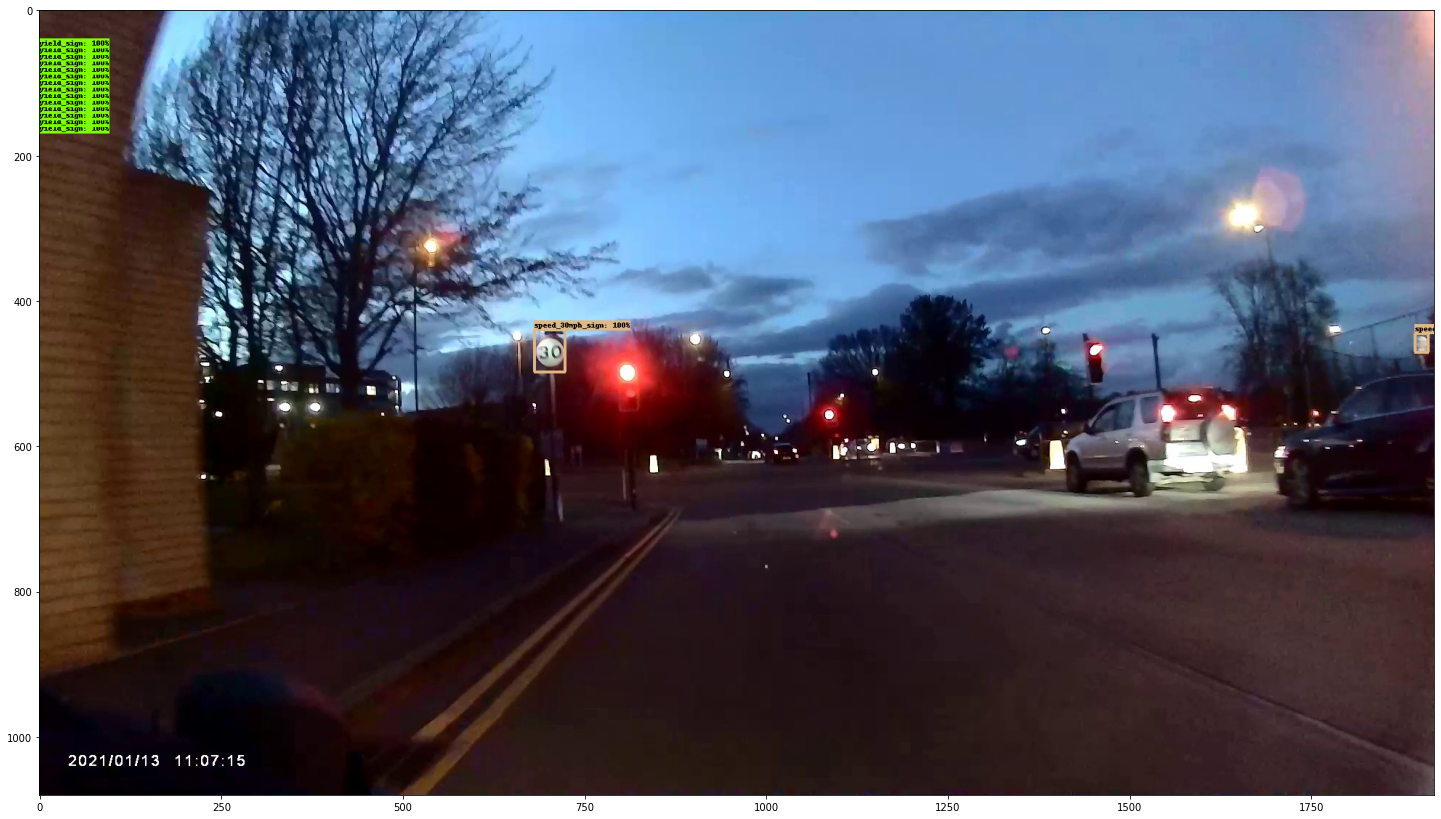

In [ ]:
%matplotlib inline
yield_class_id = 1
pedestrians_crossing_class_id = 2
no_entry_class_id = 3
chevron_left_class_id = 4
chevron_right_class_id = 5
parking_class_id = 6
stop_class_id = 7
speed_60mph_class_id = 8
speed_30mph_class_id = 9
one_way_class_id = 10
speed_bump_class_id = 11
no_left_turn_class_id = 12
no_heavy_goods_vehicles_class_id = 13
no_right_turn_class_id = 14
children_class_id = 15

num_classes = 15

category_index = {
      yield_class_id: {'id': yield_class_id, 'name': 'yield_sign'},
      pedestrians_crossing_class_id: {'id': pedestrians_crossing_class_id, 'name': 'pedestrians_crossing_sign'},
      no_entry_class_id: {'id': no_entry_class_id, 'name': 'no_entry_sign'},
      chevron_left_class_id: {'id': chevron_left_class_id, 'name': 'chevron_left_sign'},
      chevron_left_class_id: {'id': chevron_right_class_id, 'name': 'chevron_left_sign'},
      parking_class_id: {'id': parking_class_id, 'name': 'parking_sign'},
      stop_class_id: {'id': stop_class_id, 'name': 'stop_sign'},
      speed_60mph_class_id: {'id': speed_60mph_class_id, 'name': 'speed_60mph_sign'},
      speed_30mph_class_id: {'id': speed_30mph_class_id, 'name': 'speed_30mph_sign'},
      one_way_class_id: {'id': one_way_class_id, 'name': 'one_way_sign'},
      speed_bump_class_id: {'id': speed_bump_class_id, 'name': 'speed_bump_sign'},
      no_left_turn_class_id: {'id': no_left_turn_class_id, 'name': 'no_left_turn_sign'},
      no_heavy_goods_vehicles_class_id: {'id': no_heavy_goods_vehicles_class_id, 'name': 'no_heavy_goods_vehicles_sign'},
      no_right_turn_class_id: {'id': no_right_turn_class_id, 'name': 'no_right_turn_sign'},
      children_class_id: {'id': children_class_id, 'name': 'children_sign'}
    }

offset = 0

image_np = test_images_np[offset]
image_np_with_annotations = image_np.copy()
boxes = gt_boxes_flat[offset]
classes = class_arrays_for_frames[offset]
scores = dummy_scores_for_frames[offset]
# For a given frame, (offset), plot all the BBoxes that appear
viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_annotations, # Image
    boxes, # 15 Boxes [N, 4] - all for this frame
    #np.ones(shape=[np.asarray(gt_boxes_all)[offset].shape[0]], dtype=np.int32), # Classes
    #np.asarray([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]),
    classes,
    scores,
    category_index,
    use_normalized_coordinates=True,
    min_score_thresh=0.8)

plt.figure(figsize=(25, 25))
plt.imshow(image_np_with_annotations)

In [ ]:
if path.exists('frames_annotated') == False:
    os.mkdir('frames_annotated')
else:
    shutil.rmtree('frames_annotated')
    os.mkdir('frames_annotated')

plt.figure(figsize=(30, 15))
for idx in range(len(gt_boxes_all)):
  filename = "frame%s.jpg" % str(idx).zfill(4)
  image_np = test_images_np[idx]
  image_np_with_annotations = image_np.copy()
  boxes = gt_boxes_flat[idx]
  classes = class_arrays_for_frames[idx]
  scores = dummy_scores_for_frames[idx]
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes, # 15 Boxes [N, 4] - all for this frame
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if path.exists("frames_annotated/" + filename) == False:
      #cv2.imwrite("frames_annotated/" + filename, image_np_with_annotations)     # save frame as JPEG file      
      plt.imsave('frames_annotated/' + filename, image_np_with_annotations)

<Figure size 2160x1080 with 0 Axes>

In [ ]:
!zip -r frames_annotated.zip frames_annotated/

updating: frames_annotated/ (stored 0%)
updating: frames_annotated/frame0023.jpg (deflated 2%)
updating: frames_annotated/frame0011.jpg (deflated 3%)
updating: frames_annotated/frame0018.jpg (deflated 2%)
updating: frames_annotated/frame0030.jpg (deflated 1%)
updating: frames_annotated/frame0025.jpg (deflated 2%)
updating: frames_annotated/frame0050.jpg (deflated 1%)
updating: frames_annotated/frame0022.jpg (deflated 2%)
updating: frames_annotated/frame0034.jpg (deflated 1%)
updating: frames_annotated/frame0046.jpg (deflated 1%)
updating: frames_annotated/frame0036.jpg (deflated 1%)
updating: frames_annotated/frame0021.jpg (deflated 2%)
updating: frames_annotated/frame0026.jpg (deflated 2%)
updating: frames_annotated/frame0055.jpg (deflated 1%)
updating: frames_annotated/frame0028.jpg (deflated 2%)
updating: frames_annotated/frame0040.jpg (deflated 2%)
updating: frames_annotated/frame0043.jpg (deflated 1%)
updating: frames_annotated/frame0019.jpg (deflated 2%)
updating: frames_annotate

Form GIF:
50 is the default duration (use with fps = 30). Adjust accordingly

In [ ]:
images = glob.glob(f"frames_annotated/*.jpg")
images.sort()
frames = [Image.open(image) for image in images]
frame_one = frames[0]
frame_one.save("gif_test_annotated.gif", format="GIF", append_images=frames,
                save_all=True, duration=50, loop=0)
display(IPyImage(open("gif_test_annotated.gif", 'rb').read()))

# Preparing ground_truth for evaluation

**IMPORTANT - Adjust ground_truth_video to the format returned by the model**

x1 = dist from left
y1 = dist from top

Above: 

*   ground_truth_video: List of class_prediction
 *   class_prediction: List of predictions for EACH frame of A GIVEN class.
  *   predictions: List of BBox in an image, for a class
   *   BBox: [y1, x1, y2, x2]

Below:

*   video_predictions: List of frame_predictions
 *   frame_predictions: List of predictions in A GIVEN frame for EACH class
  *   predictions: List of BBox in an image, for a classs
   *   BBox: ([x1, y1, x2, y2, confidence], class_id)


## Reshape to video = [frame], frame = [class_pred], class_pred = [Bbox]
We need it shaped like the output from the model:

In [95]:
ground_truth_video_transposed = [[gt_boxes_0[i],gt_boxes_1[i],gt_boxes_2[i],gt_boxes_3[i],gt_boxes_4[i],gt_boxes_5[i],gt_boxes_6[i],gt_boxes_7[i],gt_boxes_8[i],gt_boxes_9[i],gt_boxes_10[i],gt_boxes_11[i],gt_boxes_12[i],gt_boxes_13[i],gt_boxes_14[i]] for i in range(0, len(gt_boxes_0))]
ground_truth_video_transposed[10]

[array([[0.32940755, 0.11041667, 0.42607422, 0.15625   ]]),
 None,
 array([[0.45440755, 0.65625   , 0.49440755, 0.66927083]]),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 array([[0.41107422, 0.11822917, 0.51940755, 0.14322917]]),
 None]

## Convert to native resolution, add Confidence and Frame Number
We need to convert to Native: (1920x1080)

We should set the Bbox confidence to "1" as this is the ground_truth.

We should also add a "Frame Number" to each Bbox, so we can order them by confidence later and retain the knowledge of their order in the video

In [96]:
gt_video_native = np.copy(ground_truth_video_transposed)
frame_num = 0
for class_predictions in ground_truth_video_transposed:
  class_num = 0
  for item in class_predictions:
    if item is not None:
      BBox_Num = 0
      BBoxes = []
      for BBox in item:
        BBox[0] = BBox[0] * 1080
        BBox[1] = BBox[1] * 1920
        BBox[2] = BBox[2] * 1080
        BBox[3] = BBox[3] * 1920
        BBox = np.append(BBox, np.asarray([1, frame_num]))
        BBoxes.append(BBox)
        BBox_Num = BBox_Num + 1
      gt_video_native[frame_num][class_num] = BBoxes
    class_num = class_num + 1
  frame_num = frame_num + 1

gt_video_native[10]

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


array([list([array([355.760154 , 212.0000064, 460.1601576, 300.       ,   1.       ,
               10.       ])])                                                       ,
       None,
       list([array([4.90760154e+02, 1.26000000e+03, 5.33960154e+02, 1.28499999e+03,
              1.00000000e+00, 1.00000000e+01])])                                   ,
       None, None, None, None, None, None, None, None, None, None,
       list([array([443.9601576, 227.0000064, 560.960154 , 275.0000064,   1.       ,
               10.       ])])                                                       ,
       None], dtype=object)

## Adjust Bounding Boxes
We also need the Bounding Boxes adjusted:
(first pair and second pair of values swapped)

In [97]:
gt_video_native_old = np.copy(gt_video_native)
frame_num = 0
for frame_predictions in gt_video_native_old: # For each frame in the model
  i = 0
  for item in frame_predictions: # For each class in the frame
    class_id = labels[i]
    if item is not None:
      Bbox_num = 0
      Bboxes = []
      result = []
      for BBox in item:
        temp = BBox[1]
        BBox[1] = BBox[0]
        BBox[0] = temp
        temp = BBox[3]
        BBox[3] = BBox[2]
        BBox[2] = temp
gt_video_native_old[10]

array([list([array([212.0000064, 355.760154 , 300.       , 460.1601576,   1.       ,
               10.       ])])                                                       ,
       None,
       list([array([1.26000000e+03, 4.90760154e+02, 1.28499999e+03, 5.33960154e+02,
              1.00000000e+00, 1.00000000e+01])])                                   ,
       None, None, None, None, None, None, None, None, None, None,
       list([array([227.0000064, 443.9601576, 275.0000064, 560.960154 ,   1.       ,
               10.       ])])                                                       ,
       None], dtype=object)

In [98]:
frame_num = 0
for frame_predictions in gt_video_native: # For each frame in the model
  i = 0
  for item in frame_predictions: # For each class in the frame
    class_id = labels[i]
    if item is not None:
      Bbox_num = 0
      Bboxes = []
      for BBox in item: # Each BBox in the class prediction
        result = []
        #result.append(BBox[1])
        #result.append(BBox[0])
        #result.append(BBox[3])
        #result.append(BBox[2])
        result.append(BBox[0])
        result.append(BBox[1])
        result.append(BBox[2])
        result.append(BBox[3])
        result.append(BBox[4])
        result.append(BBox[5])
        
        resulting_box = (result, class_id)
        Bboxes.append(resulting_box)
        Bbox_num = Bbox_num + 1
      gt_video_native[frame_num][i] = Bboxes
      
    i = i + 1
  frame_num = frame_num + 1

gt_video_native[10]

array([list([([212.0000064, 355.760154, 300.0, 460.1601576, 1.0, 10.0], 'yield_sign')]),
       None,
       list([([1260.0, 490.760154, 1284.9999936, 533.960154, 1.0, 10.0], 'no_entry_sign')]),
       None, None, None, None, None, None, None, None, None, None,
       list([([227.0000064, 443.9601576, 275.00000639999996, 560.9601540000001, 1.0, 10.0], 'no_right_turn_sign')]),
       None], dtype=object)

In [99]:
gt_video_native[10]

array([list([([212.0000064, 355.760154, 300.0, 460.1601576, 1.0, 10.0], 'yield_sign')]),
       None,
       list([([1260.0, 490.760154, 1284.9999936, 533.960154, 1.0, 10.0], 'no_entry_sign')]),
       None, None, None, None, None, None, None, None, None, None,
       list([([227.0000064, 443.9601576, 275.00000639999996, 560.9601540000001, 1.0, 10.0], 'no_right_turn_sign')]),
       None], dtype=object)

In [100]:
gt_video_native_old[10]

array([list([array([212.0000064, 355.760154 , 300.       , 460.1601576,   1.       ,
               10.       ])])                                                       ,
       None,
       list([array([1.26000000e+03, 4.90760154e+02, 1.28499999e+03, 5.33960154e+02,
              1.00000000e+00, 1.00000000e+01])])                                   ,
       None, None, None, None, None, None, None, None, None, None,
       list([array([227.0000064, 443.9601576, 275.0000064, 560.960154 ,   1.       ,
               10.       ])])                                                       ,
       None], dtype=object)

## Convert to simple GT format:

Convert to simple GT format:
List of frames:
*  frame: list of tuples:
 *   tuple: ([x1, y1, x2, y2], class_id)

(In evaluation, we don't need to see the empty sets)

E.g: [[([1072.8865, 858.89453, 1130.7013, 915.93134, 1], 'stop_sign'),
  ([1713.6442, 777.45941, 1739.5115, 821.59015, 1], 'no_entry_sign')]]

In [101]:
gt_video_native[10]

array([list([([212.0000064, 355.760154, 300.0, 460.1601576, 1.0, 10.0], 'yield_sign')]),
       None,
       list([([1260.0, 490.760154, 1284.9999936, 533.960154, 1.0, 10.0], 'no_entry_sign')]),
       None, None, None, None, None, None, None, None, None, None,
       list([([227.0000064, 443.9601576, 275.00000639999996, 560.9601540000001, 1.0, 10.0], 'no_right_turn_sign')]),
       None], dtype=object)

In [102]:
gt_out = []
i = 0 # Frame Number
for frame in gt_video_native:
  frame_boxes = []
  j = 0 # Class Number
  for class_pred in frame:
    if class_pred is not None:
      # BBoxes exist for this class
      #tuples = []
      for tupl in class_pred:
        #tuples.append(tupl)
        # Here, we don't need to group each tuple by class in the frame
        frame_boxes.append(tupl)

      #frame_boxes.append(tuples)
    j = j + 1
  i = i + 1
  gt_out.append(frame_boxes)

gt_video_native = gt_out
gt_video_native

[[([444.99999360000004, 451.16016119999995, 510.0, 519.5601576, 1.0, 0.0],
   'yield_sign'),
  ([1208.0000064, 523.160154, 1230.9999936000002, 553.7601612, 1.0, 0.0],
   'no_entry_sign'),
  ([459.99999360000004, 519.5601576, 495.0, 587.960154, 1.0, 0.0],
   'no_right_turn_sign')],
 [([425.00000639999996, 452.96015400000005, 495.0, 523.160154, 1.0, 1.0],
   'yield_sign'),
  ([1211.0000063999998, 528.560154, 1235.0000064, 559.1601612000001, 1.0, 1.0],
   'no_entry_sign'),
  ([443.0000064, 526.7601612, 480.99999360000004, 596.9601612, 1.0, 1.0],
   'no_right_turn_sign')],
 [([407.00000639999996,
    442.16015400000003,
    476.0000064,
    510.56016120000004,
    1.0,
    2.0],
   'yield_sign'),
  ([1217.0000064, 519.5601576, 1241.0000063999998, 553.7601612, 1.0, 2.0],
   'no_entry_sign'),
  ([426.0, 523.160154, 465.0, 591.5601612, 1.0, 2.0], 'no_right_turn_sign')],
 [([392.00000639999996, 427.76015759999996, 465.0, 501.560154, 1.0, 3.0],
   'yield_sign'),
  ([1226.0000063999998, 508.7601

# Evaluation Functions

We will calculate the mean average precision at different IOU thresholds, and average this for our performance metric

## Intersection over Union

Credit to: https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation 

In [15]:
# This gives BBoxes in a different format to our annotate function :(
def get_iou_from_model(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'y1', 'x2', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'y1', 'x2', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    union_area = float(bb1_area + bb2_area - intersection_area)
    iou = intersection_area / union_area

    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [16]:
#Individual
Bbox1 = [1182.0, 346.7601576, 1247.0000064, 415.160154, 1.0, 10.0]
Bbox2 = [1180.7995232967403, 345.5596808967404, 1245.7995296967404, 413.9596772967404, 0.9828307093782671, 10]
print(Bbox1)
print(Bbox2)
print(get_iou_from_model(Bbox1, Bbox2))

[1182.0, 346.7601576, 1247.0000064, 415.160154, 1.0, 10.0]
[1180.7995232967403, 345.5596808967404, 1245.7995296967404, 413.9596772967404, 0.9828307093782671, 10]
0.9310694031076903


## Precision and Recall

In [17]:
def calculate_precision(TP, FP, FN):
  if TP + FP == 0:
    return 0
  precision = TP / (TP + FP)
  #print("Precision = " + str(precision))
  return precision

def calculate_recall(TP, FP, FN):
  if TP + FN == 0:
    return 0
  recall = TP / (TP + FN)
  #print("recall = " + str(recall))
  return recall

calculate_precision(2, 1, 2)
calculate_recall(2, 1, 2)
print("Done!")

Done!


In [18]:
FP = 0
for i in range(0, len(gt_video_native)):
  FP = FP + len(gt_video_native[i])
print(FP)

57


## Sorting preds and ground_truth

### Flatten and Sort Preds - produce flat list of Bboxes, sorted by confidence value

In [19]:
# Out - list of class_predictions, ordered by confidence
def flatten_and_sort_preds(video_preds):
  out = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
  for frame in video_preds:
    class_id = 0
    for class_pred in frame:
      for BBox in class_pred:
        out[class_id].append(BBox)
      class_id = class_id + 1
  
  for id in range(0, len(out)):
    out[id] = sorted(out[id], key = lambda x:x[4], reverse = True)
  #out = sorted(out, key = lambda x: x[4], reverse = True)
  return out

#dummy_video_pred_sorted = flatten_and_sort_preds(dummy_video_pred)
#dummy_video_pred_sorted[2]

### Flatten and Sort Ground Truth - produce flat list of Bboxes

In [20]:
def flatten_gt(ground_truth):
  out = []
  for frame in ground_truth:
    for item in frame:
      out.append(item)
  return out

#gt_dummy_flat = flatten_gt(gt_dummy)
#gt_dummy_flat[0:5]

## mAP functions


### Average Precision (AP)
Uses functions above to calculate average precision for a given class in the video

In [21]:
# Calculate the Average Precision for a given class's predictions in the video
def calculate_AP_video_sorted(class_preds, predicted_class, ground_truth, iou_threshold, verbose):
  TP = 0
  FP = 0
  #FN = len(ground_truth)
  correct_vals = []
  precision_vals = []
  recall_vals = []

  real_signs_for_class = [sign for sign in ground_truth if sign[1] == predicted_class]
  FN = len(real_signs_for_class)
  # Also need a "Real Signs for Frame"
  if verbose == True:
    print("Class = " + str(predicted_class))
    print("Real Signs for class = " + str(real_signs_for_class))

  if class_preds != []:
    for BBox in class_preds: # Ordered by confidence
      # Check prediction against ground_truth
      real_signs_in_frame = [sign for sign in real_signs_for_class if sign[0][5] == BBox[5]]
      if verbose == True:
        print("Prediction = " + str(BBox))
        print("Real Signs in frame = " + str(real_signs_in_frame))
      correct = False
      if FN > 0: # There are real signs still left to predict
        for real_sign in real_signs_in_frame: # For each sign in the frame (could be zero)
          # Does the BBox match this sign?
          iou = get_iou_from_model(BBox[0:4], real_sign[0][0:4])
          if verbose == True:
            print("Real Sign  = " + str(real_sign))
            print("IOU = " + str(iou))
          if iou > iou_threshold:
            # Correct prediction, update TP
            if verbose == True:
              print("IOU above threshold")
            TP = TP + 1
            FN = FN - 1
            correct = True # Found a corresponding sign
            # Remove sign from ground_truth -> In case there's a duplicate prediction here
            ground_truth.remove(real_sign)
            real_signs_for_class.remove(real_sign)
            real_signs_in_frame.remove(real_sign)
            break
        if correct == False: # Didn't find a corresponding sign
          FP = FP + 1
      else: # No signs left, but a sign predicted.
        FP = FP + 1

      # Calculate Precision and recall
      if verbose == True:
        print("TP, FP, FN: " + str(TP) + " " + str(FP) + " " + str(FN))
      precision = calculate_precision(TP, FP, FN)
      if verbose == True:
        print("     Precision (TP / (TP + FP)) = " + str(precision))
      recall = calculate_recall(TP, FP, FN)
      if verbose == True:
        print("     Recall (TP / (TP + FN)) = " + str(recall))

      correct_vals.append(correct)
      precision_vals.append(precision)
      recall_vals.append(recall)
    
    # Completed Class Prediction Checking, calculate Average Precision
    precision_recalls = [[precision_vals[i], recall_vals[i]] for i in range(0, len(precision_vals))]
    if verbose == True:
      print(precision_recalls)
    AP = max_precisions(precision_recalls, verbose)

  else:
    # No predictions made for class -> Average Precision 0 or 1
    if real_signs_for_class == []:
      # No signs of this class exist at all, AP = 1
      AP = 1
    else:
      # Signs of this class exist, AP = 0
      AP = 0
  if verbose == True:
      print("AP = " + str(AP))
  return AP

#### Max Precisions
Obtains the max average precision obtained with recall values between 0 and 1

In [22]:
def max_precisions(precision_recalls, verbose):
  maxes = []
  for n in range (0, 11):
    target_recall = n/10
    # Max precision obtainable with this or a higher recall:
    max_prec = 0
    for precision, recall in precision_recalls:
      if recall >= target_recall and precision > max_prec:
        max_prec = precision
    maxes.append([max_prec, target_recall])
  if verbose == True:
    print(maxes)
  result = 0
  for item in maxes:
    result = result + item[0]
  result = result / 11
  return result

max_precisions([[1.0, 0.2], [1.0, 0.4], [0.67, 0.4], [0.5, 0.4], [0.4, 0.4], [0.5, 0.6], [0.57, 0.8], [0.5, 0.8], [0.44, 0.8], [0.5, 1]], True)

[[1.0, 0.0], [1.0, 0.1], [1.0, 0.2], [1.0, 0.3], [1.0, 0.4], [0.57, 0.5], [0.57, 0.6], [0.57, 0.7], [0.57, 0.8], [0.5, 0.9], [0.5, 1.0]]


0.7527272727272728

In [23]:
max_precisions([[0.0, 0.0], [0.0, 0.0], [0.3333333333333333, 0.017543859649122806], [0.25, 0.017543859649122806], [0.2, 0.017543859649122806], [0.16666666666666666, 0.017543859649122806], [0.2857142857142857, 0.03508771929824561], [0.25, 0.03508771929824561], [0.3333333333333333, 0.05263157894736842], [0.4, 0.07017543859649122], [0.36363636363636365, 0.07017543859649122], [0.3333333333333333, 0.07017543859649122], [0.38461538461538464, 0.08771929824561403], [0.42857142857142855, 0.10526315789473684], [0.4, 0.10526315789473684], [0.4375, 0.12280701754385964], [0.47058823529411764, 0.14035087719298245], [0.5, 0.15789473684210525], [0.47368421052631576, 0.15789473684210525], [0.45, 0.15789473684210525], [0.42857142857142855, 0.15789473684210525], [0.4090909090909091, 0.15789473684210525], [0.391304347826087, 0.15789473684210525], [0.375, 0.15789473684210525], [0.36, 0.15789473684210525], [0.38461538461538464, 0.17543859649122806], [0.37037037037037035, 0.17543859649122806], [0.39285714285714285, 0.19298245614035087], [0.41379310344827586, 0.21052631578947367], [0.43333333333333335, 0.22807017543859648], [0.41935483870967744, 0.22807017543859648], [0.40625, 0.22807017543859648], [0.42424242424242425, 0.24561403508771928], [0.4117647058823529, 0.24561403508771928], [0.4, 0.24561403508771928], [0.4166666666666667, 0.2631578947368421], [0.43243243243243246, 0.2807017543859649], [0.42105263157894735, 0.2807017543859649], [0.41025641025641024, 0.2807017543859649], [0.425, 0.2982456140350877], [0.43902439024390244, 0.3157894736842105], [0.42857142857142855, 0.3157894736842105], [0.4186046511627907, 0.3157894736842105], [0.4090909090909091, 0.3157894736842105], [0.4, 0.3157894736842105], [0.41304347826086957, 0.3333333333333333], [0.40425531914893614, 0.3333333333333333], [0.4166666666666667, 0.3508771929824561], [0.42857142857142855, 0.3684210526315789], [0.44, 0.38596491228070173], [0.43137254901960786, 0.38596491228070173], [0.4423076923076923, 0.40350877192982454], [0.4528301886792453, 0.42105263157894735], [0.46296296296296297, 0.43859649122807015], [0.4727272727272727, 0.45614035087719296], [0.4642857142857143, 0.45614035087719296], [0.47368421052631576, 0.47368421052631576]], True)

[[0.5, 0.0], [0.5, 0.1], [0.47368421052631576, 0.2], [0.47368421052631576, 0.3], [0.47368421052631576, 0.4], [0, 0.5], [0, 0.6], [0, 0.7], [0, 0.8], [0, 0.9], [0, 1.0]]


0.22009569377990432

### Mean Average Precision (mAP)
Average of APs for every class

For each class, get the predictions made in each frame.
Sort by confidence value
Pass to AP to calculate Average Precision as Recall increases









In [24]:
# Calculate the mean Average Precision for a given iou threshold, for a video of predictions
def calculate_mAP_video_sorted(video_predictions, ground_truth, iou_threshold, verbose):
  mAP = 0
  APs = []

  label = 0
  for class_pred in video_predictions:
    # For each class, calculate the AP across the video (these are ordered by confidence)
    AP = calculate_AP_video_sorted(class_pred, labels[label], flatten_gt(ground_truth), iou_threshold, verbose)
    APs.append(AP)
    mAP = mAP + AP
    label = label + 1
  
  print("APs = " + str(APs))
  mAP = mAP / len(labels)
  print("mAP = " + str(mAP))
  return mAP

#calculate_mAP_video_sorted(dummy_video_pred_sorted, gt_dummy, 0.5, False)

### average mAP
Average mAP for IOU thresholds between 0.5 and 0.95

In [25]:
def print_labels(labels):
  label_arr = []
  for label in labels:
    label_arr.append(label)
  print(label_arr)
  return 0

In [26]:
# compute mAP for different IOU thresholds (0.5, 0.55, 0.6, ... 0.95) and the final metric is the mean of all these mAPs
def calculate_average_mAP_video_sorted(video_predictions, ground_truth, verbose):
  print_labels(labels)
  mAPs = []
  average_mAP = 0
  for value in range (50, 95, 5):
    iou_threshold = value / 100
    mAP = calculate_mAP_video_sorted(video_predictions, ground_truth, iou_threshold, verbose)
    mAPs.append(mAP)
    average_mAP = average_mAP + mAP
  
  average_mAP = average_mAP / len(mAPs)
  print("mAPs = " + str(mAPs))
  print("average_mAP = " + str(average_mAP))
  return average_mAP

#calculate_average_mAP_video_sorted(dummy_video_pred_sorted, gt_dummy, False)


# Preparing predictions for evaluation

We need to produce the following values: 

* predictions -> array of predictions for each frame
  * frame -> array of predictions for each class
    * class -> array of BBoxes for each (frame, class) pair

* ground_truth -> array of real values for each frame
  * frame -> array of real signs for each class
    * class -> array of real Bboxes for each (frame, class) pair

## Dummy Prediction

Produce some random values - similar to the actual bboxes. For ground_truth_video (multi-class data).

This is to illustrate the AP and mAP functions in their full purpose, in case the model fails to provide reasonable results

* dummy_video_pred -> semi-random predictions made against video from above
* gt_dummy -> real signs in video

Confidence values random between 0.5 and 1

In [ ]:
gt_video_native[10]

[([888.9999936, 467.362494, 923.0000064, 517.7624976, 1.0, 10.0],
  'no_entry_sign')]

In [ ]:
gt_video_native_old[0]

array([None, None,
       list([array([9.89000006e+02, 4.72762494e+02, 1.01900001e+03, 5.12362498e+02,
              1.00000000e+00, 0.00000000e+00])])                                   ,
       None, None, None, None, None, None, None, None, None, None, None,
       None], dtype=object)

In [ ]:
dummy_video_pred = []
duplicate = True
for i in range(0, gt_video_native_old.shape[0]): # For each Frame, i is the frame number
  frame_preds = []
  # Form predictions for frame
  for j in range(0, gt_video_native_old.shape[1]): # For each Class
    if gt_video_native_old[i][j] is not None: # Signs exist for this class, make predictions
      bboxes = []
      for BboxID in range(0, len(gt_video_native_old[i][j])):
        bbox = []
        rand = 3 * gauss(0, 1)
        for k in range(0, 4):
          # set the "predicted" bbox value = actual + rand
          bbox.append(gt_video_native_old[i][j][BboxID][k] + rand)
        bbox.append(uniform(0.5, 1)) # Confidence Value
        bbox.append(i)
        bboxes.append(bbox)
        if duplicate == True:
          # Make a duplicate prediction (used for testing later)
          rand = 3 * gauss(0, 1)
          dupl_bbox = bbox.copy()
          for x in range(0, 4):
            dupl_bbox[x] = dupl_bbox[x] + rand
          dupl_bbox[4] = uniform(0.5, 1)
          bboxes.append(dupl_bbox)
          duplicate = False
      frame_preds.append(bboxes)
    else:
      frame_preds.append(None)

  dummy_video_pred.append(frame_preds)
dummy_video_pred[10]

[None,
 None,
 [[884.2518561783202,
   462.61435657832016,
   918.2518689783201,
   513.0143601783201,
   0.9193605965722735,
   10]],
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
dummy_video_pred[0]

[[],
 [],
 [[986.1743186823348,
   469.9368062823348,
   1016.1743186823348,
   509.5368098823348,
   0.6768176279182547,
   0],
  [988.6384816233874,
   472.4009692233874,
   1018.6384816233874,
   512.0009728233873,
   0.7047681874893574,
   0]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

Replace "None" values with []

In [ ]:
frame_num = 0
for frame in dummy_video_pred:
  class_num = 0
  for class_pred in frame:
    if class_pred is None:
      dummy_video_pred[frame_num][class_num] = []
    class_num = class_num + 1
  frame_num = frame_num + 1

dummy_video_pred[10]

[[],
 [],
 [[884.2518561783202,
   462.61435657832016,
   918.2518689783201,
   513.0143601783201,
   0.9193605965722735,
   10]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [ ]:
gt_video_native[10]

[([888.9999936, 467.362494, 923.0000064, 517.7624976, 1.0, 10.0],
  'no_entry_sign')]

In [ ]:
gt_video_native_old[10]

array([None, None,
       list([array([888.9999936, 467.362494 , 923.0000064, 517.7624976,   1.       ,
               10.       ])])                                                       ,
       None, None, None, None, None, None, None, None, None, None, None,
       None], dtype=object)

In [ ]:
gt_dummy = gt_video_native.copy()
gt_dummy[10]

[([888.9999936, 467.362494, 923.0000064, 517.7624976, 1.0, 10.0],
  'no_entry_sign')]

## Fetching from JSON predictions file
This will get a result outputted from our model and format it the way we need
* video_pred -> predictions from video
* gt_video_native -> real signs in video


*
*

* [[([1072.8865, 858.89453, 1130.7013, 915.93134, 1], 'stop_sign'),
*  ([1713.6442, 777.45941, 1739.5115, 821.59015, 1], 'no_entry_sign')]]

In [112]:
video_pred = []
file = "GiveWay_NoRightTurn_NoWay_Dusk_Short_output_ep15.json"
f = open(file)
data = json.load(f)

for key, value in data.items(): # For each frame's prediction
  frame_num = int(key[5:9])
  frame_pred = []
  for class_num in range(0, 15):
    class_pred = []
    # For each Bbox in this frame's prediction, add the frame number (for later)
    for Bbox_num in range(0, len(value[class_num])):
      Bbox = value[class_num][Bbox_num] 
      Bbox.append(frame_num)
      class_pred.append(Bbox)
    frame_pred.append(class_pred)
  video_pred.append(frame_pred)

f.close()

print(video_pred[10])
print(gt_video_native[10])

[[[1256.4957275390625, 496.14910888671875, 1277.136962890625, 522.052001953125, 0.0759163573384285, 10], [1250.9058837890625, 500.6585998535156, 1271.322998046875, 526.3967895507812, 0.07090821117162704, 10], [1249.583251953125, 494.53155517578125, 1270.030029296875, 520.1537475585938, 0.06854716688394547, 10], [1263.23388671875, 498.39715576171875, 1283.9423828125, 523.9306640625, 0.06467748433351517, 10], [1263.4921875, 498.0652160644531, 1283.5372314453125, 523.4041748046875, 0.06408039480447769, 10], [1234.1102294921875, 496.4783020019531, 1254.83203125, 522.5443115234375, 0.062214989215135574, 10], [1273.8350830078125, 496.2678527832031, 1294.266845703125, 522.021240234375, 0.05659516528248787, 10], [1247.7427978515625, 500.54833984375, 1268.1656494140625, 526.8364868164062, 0.05628996342420578, 10], [1271.860107421875, 501.4772644042969, 1292.249755859375, 526.9287109375, 0.05561366304755211, 10], [1250.05126953125, 505.1865539550781, 1271.8428955078125, 531.1219482421875, 0.0553

## Sample image with predictions
Here is one image from the dataset containing several predictions (some right and wrong) to demonstrate that the mAP and AP functions work on images and videos

* image_pred -> predictions from image
* gt_image -> real signs in image

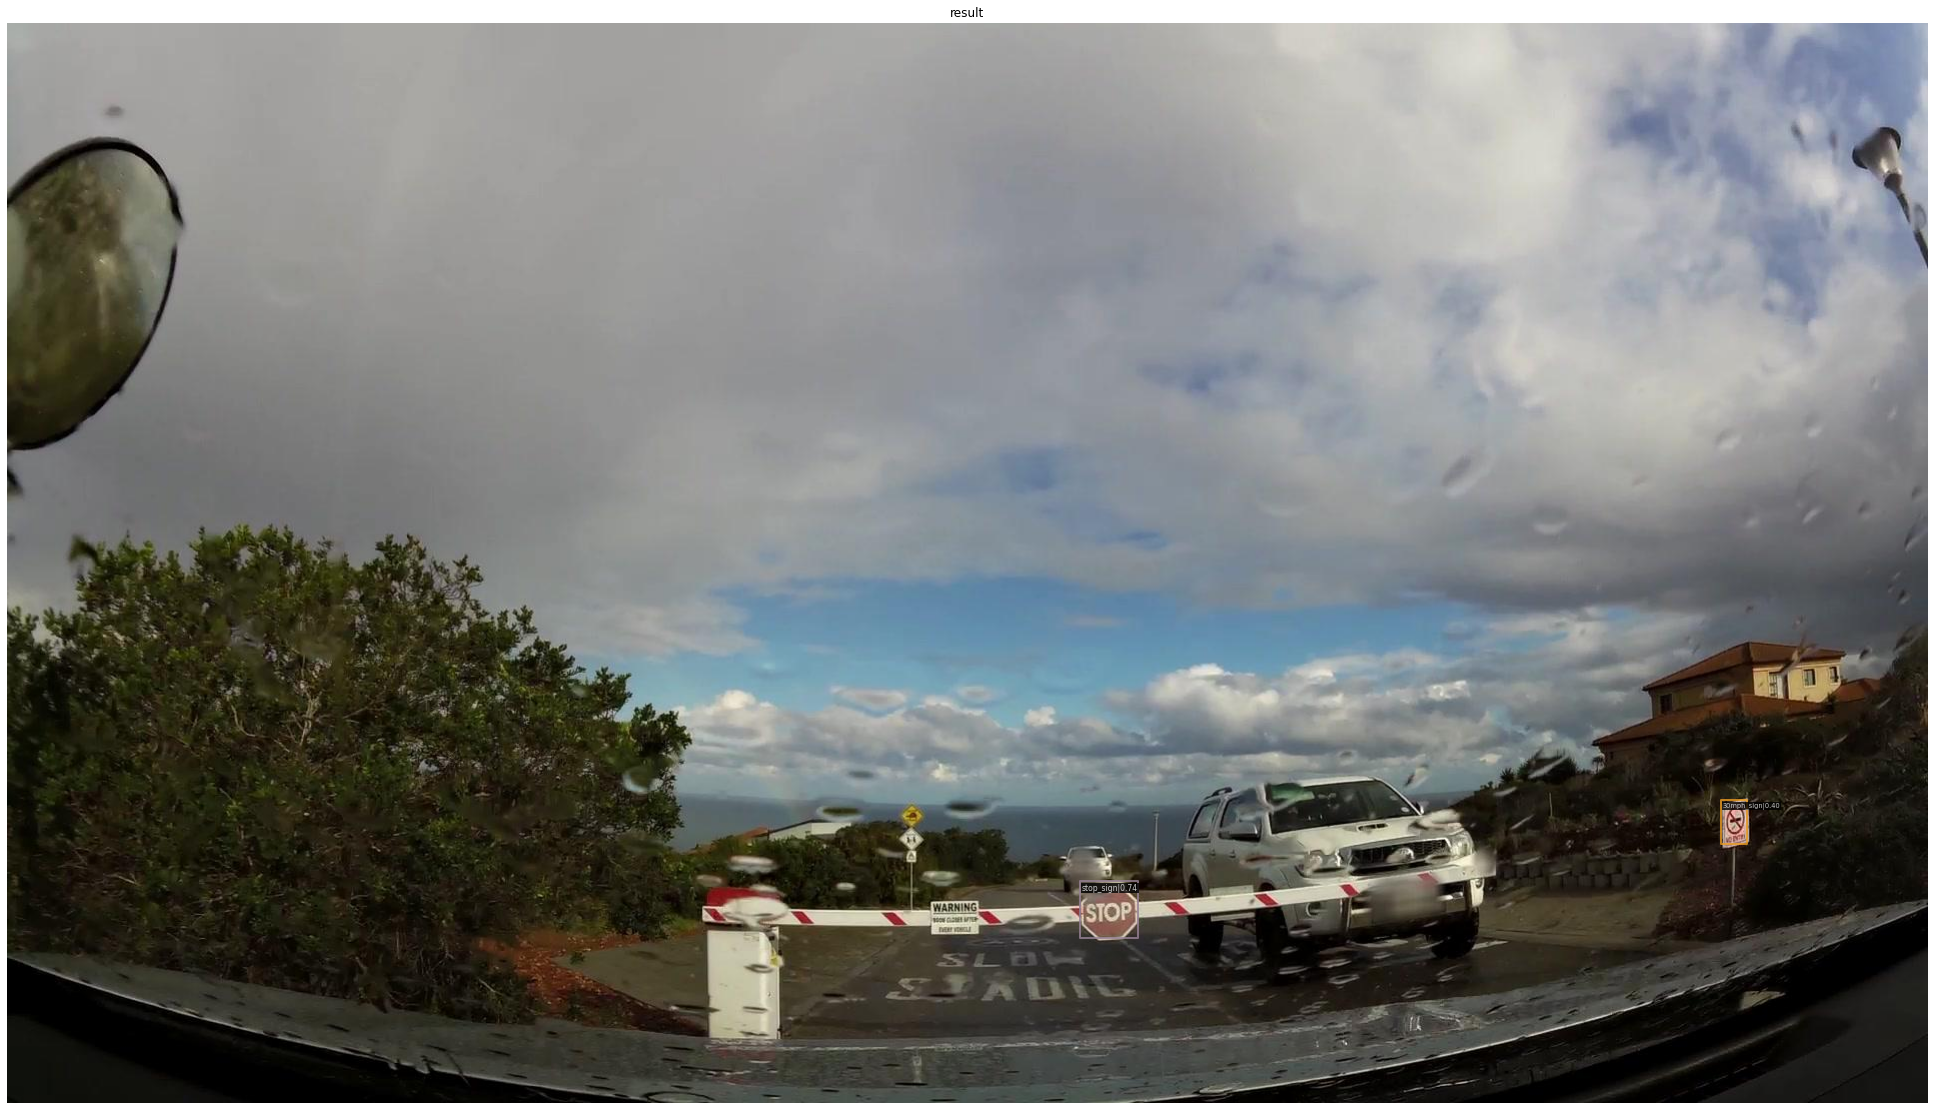

In [ ]:
labels

('yield_sign',
 'pedestrians_crossing_sign',
 'no_entry_sign',
 'chevron_left_sign',
 'chevron_right_sign',
 'parking_sign',
 'stop_sign',
 '60mph_sign',
 '30mph_sign',
 'one_way_sign',
 'speed_bump_sign',
 'no_left_turn_sign',
 'no_heavy_goods_vehicles_sign',
 'no_right_turn_sign',
 'children_sign')

In [ ]:
# Threshold for confidence = 0.4, 0.35 perhaps?

# video_predictions: List of frame_predictions, where:
#   frame_predictions = List of class_predictions, where:
#      class_prediction = array of BBoxes, predicting locations of a sign/signs of a class in an image, where:
#         BBox = shape=(0, 5) [x1, y1, x2, y2]

# labels: list of classes corresponding to each element in frame_predictions

#e.g BBox for Stop sign above = [1073, 858, 1131, 916]

image_pred = [[[], 
                      [], 
                      [], 
                      [], 
                      [], 
                      [], 
                      np.array([[1.0728865e+03, 8.5889453e+02, 1.1307013e+03, 9.1593134e+02, 7.4230129e-01, 0]], dtype=np.dtype('float32')), 
                      np.array([[1.7133292e+03, 7.7451752e+02, 1.7418207e+03, 8.2251270e+02, 1.1540503e-01, 0], [1.0703461e+03, 8.6415332e+02, 1.1295435e+03, 9.1283069e+02, 6.2164597e-02, 0]], dtype=np.dtype('float32')), 
                      np.array([[1.7136442e+03, 7.7745941e+02, 1.7395115e+03, 8.2159015e+02, 3.9843214e-01, 0], [1.0693700e+03, 8.6361481e+02, 1.1317241e+03, 9.1536078e+02, 1.8784316e-01, 0]], dtype=np.dtype('float32')), 
                      [], 
                      np.array([[8.9369348e+02, 7.8120294e+02, 9.1487445e+02, 8.0310529e+02, 1.1875288e-01, 0]], dtype=np.dtype('float32')), 
                      [], 
                      [],  
                      [],  
                      np.array([[8.9096338e+02, 8.0479596e+02, 9.1585229e+02, 8.2865613e+02, 2.1404675e-01, 0],[8.9241437e+02, 7.8086255e+02, 9.1456201e+02, 8.0451337e+02, 1.7298540e-01, 0]], np.dtype('float32'))]]
image_pred

[[[],
  [],
  [],
  [],
  [],
  [],
  array([[1.0728865e+03, 8.5889453e+02, 1.1307013e+03, 9.1593134e+02,
          7.4230129e-01, 0.0000000e+00]], dtype=float32),
  array([[1.7133292e+03, 7.7451752e+02, 1.7418207e+03, 8.2251270e+02,
          1.1540503e-01, 0.0000000e+00],
         [1.0703461e+03, 8.6415332e+02, 1.1295435e+03, 9.1283069e+02,
          6.2164597e-02, 0.0000000e+00]], dtype=float32),
  array([[1.7136442e+03, 7.7745941e+02, 1.7395115e+03, 8.2159015e+02,
          3.9843214e-01, 0.0000000e+00],
         [1.0693700e+03, 8.6361481e+02, 1.1317241e+03, 9.1536078e+02,
          1.8784316e-01, 0.0000000e+00]], dtype=float32),
  [],
  array([[8.9369348e+02, 7.8120294e+02, 9.1487445e+02, 8.0310529e+02,
          1.1875288e-01, 0.0000000e+00]], dtype=float32),
  [],
  [],
  [],
  array([[8.9096338e+02, 8.0479596e+02, 9.1585229e+02, 8.2865613e+02,
          2.1404675e-01, 0.0000000e+00],
         [8.9241437e+02, 7.8086255e+02, 9.1456201e+02, 8.0451337e+02,
          1.7298540e-01, 

In [ ]:
# Ground truth of signs above
# List of "truths" for each frame in the image (obviously just 1 here, but should be the format for videos)
gt_image = [[([1.0728865e+03, 8.5889453e+02, 1.1307013e+03, 9.1593134e+02, 1, 0], "stop_sign"),([1.7136442e+03, 7.7745941e+02, 1.7395115e+03, 8.2159015e+02, 1, 0], "no_entry_sign")]]
gt_image

[[([1072.8865, 858.89453, 1130.7013, 915.93134, 1, 0], 'stop_sign'),
  ([1713.6442, 777.45941, 1739.5115, 821.59015, 1, 0], 'no_entry_sign')]]

# Testing

## Test with Dummy Data

In [28]:
labels

('yield_sign',
 'pedestrians_crossing_sign',
 'no_entry_sign',
 'chevron_left_sign',
 'chevron_right_sign',
 'parking_sign',
 'stop_sign',
 '60mph_sign',
 '30mph_sign',
 'one_way_sign',
 'speed_bump_sign',
 'no_left_turn_sign',
 'no_heavy_goods_vehicles_sign',
 'no_right_turn_sign',
 'children_sign')

In [29]:
dummy_video_pred_sorted = flatten_and_sort_preds(dummy_video_pred)

NameError: ignored

In [ ]:
calculate_mAP_video_sorted(dummy_video_pred_sorted, gt_dummy.copy(), 0.9, False)

APs = [1, 1, 0.1477692566054635, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mAP = 0.9431846171070309


0.9431846171070309

In [ ]:
calculate_average_mAP_video_sorted(dummy_video_pred_sorted, gt_dummy.copy(), False)

['yield_sign', 'pedestrians_crossing_sign', 'no_entry_sign', 'chevron_left_sign', 'chevron_right_sign', 'parking_sign', 'stop_sign', '60mph_sign', '30mph_sign', 'one_way_sign', 'speed_bump_sign', 'no_left_turn_sign', 'no_heavy_goods_vehicles_sign', 'no_right_turn_sign', 'children_sign']
APs = [1, 1, 0.9921630094043885, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mAP = 0.9994775339602925
APs = [1, 1, 0.9921630094043885, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mAP = 0.9994775339602925
APs = [1, 1, 0.8882872613280136, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mAP = 0.9925524840885342
APs = [1, 1, 0.8463949843260188, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mAP = 0.9897596656217346
APs = [1, 1, 0.7304075235109717, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mAP = 0.9820271682340649
APs = [1, 1, 0.7194357366771161, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mAP = 0.9812957157784744
APs = [1, 1, 0.5926573426573426, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mAP = 0.9728438228438229
APs = [1, 1, 0.33896725284285095, 1, 1, 1, 1, 1, 1, 1,

0.9796166324204189

## Test with image above

In [ ]:
labels

('yield_sign',
 'pedestrians_crossing_sign',
 'no_entry_sign',
 'chevron_left_sign',
 'chevron_right_sign',
 'parking_sign',
 'stop_sign',
 '60mph_sign',
 '30mph_sign',
 'one_way_sign',
 'speed_bump_sign',
 'no_left_turn_sign',
 'no_heavy_goods_vehicles_sign',
 'no_right_turn_sign',
 'children_sign')

In [ ]:
image_pred_sorted = flatten_and_sort_preds(image_pred)

In [ ]:
calculate_mAP_video_sorted(image_pred_sorted, gt_image.copy(), 0.5, False)

APs = [1, 1, 0, 1, 1, 1, 1.0, 0.0, 0.0, 1, 0.0, 1, 1, 1, 0.0]
mAP = 0.6666666666666666


0.6666666666666666

In [ ]:
calculate_average_mAP_video_sorted(image_pred_sorted, gt_image.copy(), False)

['yield_sign', 'pedestrians_crossing_sign', 'no_entry_sign', 'chevron_left_sign', 'chevron_right_sign', 'parking_sign', 'stop_sign', '60mph_sign', '30mph_sign', 'one_way_sign', 'speed_bump_sign', 'no_left_turn_sign', 'no_heavy_goods_vehicles_sign', 'no_right_turn_sign', 'children_sign']
APs = [1, 1, 0, 1, 1, 1, 1.0, 0.0, 0.0, 1, 0.0, 1, 1, 1, 0.0]
mAP = 0.6666666666666666
APs = [1, 1, 0, 1, 1, 1, 1.0, 0.0, 0.0, 1, 0.0, 1, 1, 1, 0.0]
mAP = 0.6666666666666666
APs = [1, 1, 0, 1, 1, 1, 1.0, 0.0, 0.0, 1, 0.0, 1, 1, 1, 0.0]
mAP = 0.6666666666666666
APs = [1, 1, 0, 1, 1, 1, 1.0, 0.0, 0.0, 1, 0.0, 1, 1, 1, 0.0]
mAP = 0.6666666666666666
APs = [1, 1, 0, 1, 1, 1, 1.0, 0.0, 0.0, 1, 0.0, 1, 1, 1, 0.0]
mAP = 0.6666666666666666
APs = [1, 1, 0, 1, 1, 1, 1.0, 0.0, 0.0, 1, 0.0, 1, 1, 1, 0.0]
mAP = 0.6666666666666666
APs = [1, 1, 0, 1, 1, 1, 1.0, 0.0, 0.0, 1, 0.0, 1, 1, 1, 0.0]
mAP = 0.6666666666666666
APs = [1, 1, 0, 1, 1, 1, 1.0, 0.0, 0.0, 1, 0.0, 1, 1, 1, 0.0]
mAP = 0.6666666666666666
APs = [1, 1, 0, 

0.6666666666666666

In [ ]:
labels

('yield_sign',
 'pedestrians_crossing_sign',
 'no_entry_sign',
 'chevron_left_sign',
 'chevron_right_sign',
 'parking_sign',
 'stop_sign',
 '60mph_sign',
 '30mph_sign',
 'one_way_sign',
 'speed_bump_sign',
 'no_left_turn_sign',
 'no_heavy_goods_vehicles_sign',
 'no_right_turn_sign',
 'children_sign')

## Test with Model Output

In [30]:
labels

('yield_sign',
 'pedestrians_crossing_sign',
 'no_entry_sign',
 'chevron_left_sign',
 'chevron_right_sign',
 'parking_sign',
 'stop_sign',
 '60mph_sign',
 '30mph_sign',
 'one_way_sign',
 'speed_bump_sign',
 'no_left_turn_sign',
 'no_heavy_goods_vehicles_sign',
 'no_right_turn_sign',
 'children_sign')

In [113]:
video_pred_sorted = flatten_and_sort_preds(video_pred)
calculate_mAP_video_sorted(video_pred_sorted, gt_video_native.copy(), 0.5, False)

APs = [0.1876094212884939, 1, 0.0674412983824101, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 0.0, 1, 0.0, 0, 0.0]
mAP = 0.2170033813113936


0.2170033813113936

In [114]:
calculate_average_mAP_video_sorted(video_pred_sorted, gt_video_native.copy(), False)

['yield_sign', 'pedestrians_crossing_sign', 'no_entry_sign', 'chevron_left_sign', 'chevron_right_sign', 'parking_sign', 'stop_sign', '60mph_sign', '30mph_sign', 'one_way_sign', 'speed_bump_sign', 'no_left_turn_sign', 'no_heavy_goods_vehicles_sign', 'no_right_turn_sign', 'children_sign']
APs = [0.1876094212884939, 1, 0.0674412983824101, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 0.0, 1, 0.0, 0, 0.0]
mAP = 0.2170033813113936
APs = [0.1876094212884939, 1, 0.022622319766772484, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 0.0, 1, 0.0, 0, 0.0]
mAP = 0.21401544940368442
APs = [0.18732782369146006, 1, 0.02017272807930247, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 0.0, 1, 0.0, 0, 0.0]
mAP = 0.21383337011805087
APs = [0.11263282172373082, 1, 0.0031623931623931626, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 0.0, 1, 0.0, 0, 0.0]
mAP = 0.20771968099240828
APs = [0.0949929265365507, 1, 0.0012766293043109651, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 0.0, 1, 0.0, 0, 0.0]
mAP = 0.20641797038939078
APs = [0.09480519480519481, 1, 0.0001373249107388080

0.2073539060439027